In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm
import time, sys, os

directory = 'figures'
if not os.path.exists(directory):
    os.makedirs(directory)
plt.rcParams['figure.dpi']=400

# Implementation of the TEBD for a test case

## Assignment: MPS simulations using TEBD

We will again study the quantum Ising model subject to a magnetic field with both transverse and longitudinal components:

$$
H = -J \sum_{j=1}^{L-1} \sigma_j^z \sigma_{j+1}^z - h^x \sum_{j=1}^{L} \sigma_j^x - h^z \sum_{j=1}^{L} \sigma_j^z .
$$

Set $ J = 1 $ and the magnetic field to $ (h^x, h^z) = (-1.05, 0.5) $, the same values as in Assignment 3, to allow you to test your MPS-based approach against exact diagonalization for small system sizes. Because we are now working with MPS, consider the system with open boundary conditions where the MPS simulations are most transparent. To specify a time-evolution procedure, this Hamiltonian can be arranged into three groups of commuting terms (i.e., commuting within each group): $ H = H_{\text{odd}} + H_{\text{even}} + H_{\text{field}} $, each of which can be readily exponentiated. The groupings are:

$$
H_{\text{odd}} = -J \sum_{j=1,3,5,\ldots} \sigma_j^z \sigma_{j+1}^z = -J (\sigma_1^z \sigma_2^z + \sigma_3^z \sigma_4^z + \sigma_5^z \sigma_6^z + \cdots ) ,
$$

$$
H_{\text{even}} = -J \sum_{j=2,4,6,\ldots} \sigma_j^z \sigma_{j+1}^z = -J (\sigma_2^z \sigma_3^z + \sigma_4^z \sigma_5^z + \sigma_6^z \sigma_7^z + \cdots ) ,
$$

$$
H_{\text{field}} = \sum_{j=1}^{L} (-h^x \sigma_j^x - h^z \sigma_j^z) = -h^x \sigma_1^x - h^z \sigma_1^z - h^x \sigma_2^x - h^z \sigma_2^z - h^x \sigma_3^x - h^z \sigma_3^z - \cdots .
$$

Clearly the terms in $ H_{\text{odd}} $ commute, and similarly for $ H_{\text{even}} $, so they can be exponentiated directly:

$$
e^{-itH_{\text{odd}}} = e^{itJ\sigma_1^z \sigma_2^z} e^{itJ\sigma_3^z \sigma_4^z} e^{itJ\sigma_5^z \sigma_6^z} \cdots , \quad e^{-itH_{\text{even}}} = e^{itJ\sigma_2^z \sigma_3^z} e^{itJ\sigma_4^z \sigma_5^z} e^{itJ\sigma_6^z \sigma_7^z} \cdots .
$$

Within $ H_{\text{field}} $, $ \sigma_j^x $ and $ \sigma_j^z $ do not commute on the same site. However, as these are single-site operators we can combine the terms for each $ j $ into

$$
\omega_j \equiv -h^x \sigma_j^x - h^z \sigma_j^z = \begin{bmatrix} -h^z & -h^x \\ -h^x & h^z \end{bmatrix} ,
$$

written in the $ \sigma^z $ basis. As all of the $ \omega_j $ commute, now $ e^{-itH_{\text{field}}} = e^{-it\omega_1} e^{-it\omega_2} e^{-it\omega_3} \cdots $. Each $ e^{-it\omega_j} $ can be written out using formulas for Pauli matrices, e.g., $ \exp(i\phi \mathbf{n} \cdot \sigma) = \cos(\phi) + i \sin(\phi) \mathbf{n} \cdot \sigma $ [where $ \mathbf{n} $ is a unit vector] for real time evolution, substituting hyperbolic functions for imaginary time evolution, or by direct exponentiation of the matrix. (Incidentally, you may notice that in this case other Trotter patterns than the one presented below are possible and may be more efficient. If you'd like, you can explore some of these, but the scheme outlined above will work regardless of the details of the terms in $ H $.)

### 4.1 Imaginary time evolution

"Rotate" now to imaginary time $\tau = it$ and perform TEBD for cooling to the ground state. It will turn out that in this case all the tensors are real-valued, but you should write your solution to also handle complex-valued tensors, for example using actual Hermitian conjugates rather than transposes; this will greatly simplify the process of going to real time evolution. However if your programming language is not strict about types, you may need to periodically cast complex values to reals in order to use specialized linear algebra routines.


## Test wave-function

In [2]:
def ferromagnetic_state_MPS(L):
    
    # given L, returns the MPS tensors of the ferromagnetic state.
    
    mps_tensors= []
    
    A = np.zeros((1, 2, 1), dtype = complex)
    A[0, 0, 0] = 1
    A[0, 1, 0] = 0
    
    for i in range(L):
        mps_tensors.append(A)

    return mps_tensors

## Useful troubleshooting code

In [3]:
def mps(psi, k):

    # Converts a wavefunction into mps form
    
    mps_tensors = []
    L = int(np.log2(len(psi)))  # Number of spins/sites
    psi_matrix = psi.reshape(2, 2**(L-1))

    for i in range(L-1):
        
        U, S, Vh = np.linalg.svd(psi_matrix, full_matrices=False)
        
        chi = min(k, len(S))
        
        S_truncated = S[: chi]
        U_truncated = U[:, :chi]
        Vh_truncated = Vh[:chi, :]

        mps_tensors.append(U_truncated.reshape((-1, 2, chi)))

        if i < L - 2:
            psi_matrix = (np.diag(S_truncated) @ Vh_truncated).reshape(2*chi, -1)
            
        else:
            last_tensor = (np.diag(S_truncated) @ Vh_truncated)
            mps_tensors.append(last_tensor.reshape(chi, 2, -1))

    return mps_tensors

def contract_mps_tensors(mps_tensors):

    # converts mps tensor form to a usual column vector wave-function.
    
    state = mps_tensors[0]
    
    for tensor in mps_tensors[1:]: 
        state = np.einsum('ijk,kln->ijln', state, tensor).reshape(1, -1, tensor.shape[2])
        
    return state.reshape(-1)

## Hamiltonian

In [4]:
def denseH(L, J, hx, hz, periodic):
    """
    generates the dense Hamiltonian matrix for the quantum Ising chain with both transverse and longitudinal magnetic fields
    
        Parameters:
            L (int): length of chain
            J (float): ising interaction strength
            h (float): magnetic field strength
            periodic (bool): does the chain have periodic boundary conditions?
            
        Returns:
            H (ndarray): 2^L x 2^L matrix representing the Hamiltonian operator
    """

    dim=2 ** L # dimensions of the Hilbert space
    
    H = np.zeros((dim, dim)) # initliaze the Hamiltonian
    
    "Calculation of off-diagonal elements due to the magnetic field"
    
    for beta in range(dim): # iterate over all states
        
        for j in range(1,L+1): # iterate over all sites
            
            alpha = beta ^ (1<<j-1) # flips jth bit of beta to get the state alpha that is related to beta by a single bit flip
            
            H[alpha, beta] -= hx # contribution by sigma^j_x
            
    "Calculation of diagonal elements due to Ising interaction"

    for alpha in range(dim): # iterate over all states
        
        for j in range(1, L): # iterate over all sites
            
            if 2*(alpha & (1 << j-1)) == alpha & (1 << j): # check if site j and j+1 have the same spin
                
                H[alpha, alpha] -= J # if they do, decrease the energy by the ising interaction term
                
            else:
                
                H[alpha, alpha] += J # if not, increase the energy by the ising interaction term
            
        "Diagonal elements due to longitudinal magnetic field"
        
        for j in range(1, L+1):
            
            if alpha & (1 << (j-1)) == 0:  # check if the spin at site j is up
                H[alpha, alpha] -= hz  # decrease energy for spin up
                
            else:
                H[alpha, alpha] += hz  # increase energy for spin down

        
        "Handling case of periodic boundary conditions"
                
        if periodic and L > 1: # L > 1 needed for periodicity to mean anything
            
            if (alpha & (1 << L-1)) == ((alpha & (1 << 0))*(2**(L-1))): # Check if the states at either end have the same spin
                
                H[alpha, alpha] -= J # if they do, decrease the energy by the ising interaction term
                
            else:
                
                H[alpha, alpha] += J # if not, increase the energy by the ising interaction term
                
    return H   

## Inner product of MPS

In [5]:
def inner_product(bra, ket):

    # function to output <psi|psi> when given in MPS form 
    
    result = np.einsum('jkl,mkn->ln', bra[0].conj(), ket[0])
    
    for i in range(1, len(ket)):

        A = np.einsum('jkl,mkn->jmln', bra[i].conj(), ket[i])
        result = np.einsum('jm,jmln->ln', result, A)
    
    return result.reshape(-1)[0]

## Function to calculate expectation value of Energy in MPS

In [6]:
def magnetic_term(ket, hx, hz):
    
    X = np.array([[0, 1], [1, 0]])
    Z = np.array([[1, 0], [0, -1]])
    
    L = len(ket)
    results = np.zeros(L, dtype = complex)
    
    for i in range(L):
        
        Hket = [np.copy(k) for k in ket]
    
        Hket[i] = hx*np.einsum('ij,kjm->kim', X, ket[i]) + hz*np.einsum('ij,kjm->kim', Z, ket[i])
        
        results[i] = inner_product(ket, Hket)
        
    return np.sum(results)
        

def ising_term(ket):
    
    Z = np.array([[1,0],[0,-1]])
    L = len(ket)
    results = np.zeros(L, dtype = complex)
    
    for i in range(0, L-1):
        
        Hket = [np.copy(k) for k in ket]
        
        Hket[i] = np.einsum('ij,kjm->kim', Z, ket[i])
        
        Hket[i+1] = np.einsum('ij,kjm->kim', Z, ket[i+1])
        
        results[i] = inner_product(ket, Hket)
        
    return np.sum(results)

def expectation_value_energy(ket, hx, hz, J):
    
    energy = -magnetic_term(ket, hx, hz)-J*ising_term(ket)
    norm = inner_product(ket, ket)
    
    return energy/norm

In [8]:
L = 12
J = 1
hx = -1.05
hz = 0.5
periodic = False 

tensors = ferromagnetic_state_MPS(L)
H = denseH(L, J, hx, hz, periodic)
eigs, vecs = scipy.linalg.eigh(H)

print('Energy of ground state: ', eigs[0])
print('Energy of the trial state: ', expectation_value_energy(tensors, hx, hz, J))

Energy of ground state:  -19.945778039039247
Energy of the trial state:  (-17+0j)


In [9]:
def local_gate(dt, hx, hz, ket):
    '''
        Applies the local trotter propagators to the MPS and returns the new MPS
    '''

    L = len(ket)

    w = np.array([[-hz, -hx], [-hx, hz]])
    R = scipy.linalg.expm(-dt*w)

    ket_new = []
    
    for i in range(L):
        ket_new.append(np.einsum('ij,kjm->kim', R, ket[i]))

    return ket_new

def twosite_even_gate(dt, J, ket):
    '''
        Applies the even trotter propagators to the MPS and returns the new MPS
    '''

    L = len(ket)

    Z = np.array([[1, 0],[0, -1]])
    H = dt * J * np.kron(Z, Z)
    T = scipy.linalg.expm(H).reshape(2, 2, 2, 2)

    ket_new = []
    
    for i in range(0, L-1, 2):

        A = np.einsum('ijk,klm->ijlm', ket[i], ket[i+1])
        W = np.einsum('abjl,ijlm->iabm', T, A)
        W = W.reshape(W.shape[0]*W.shape[1], -1)

        U, S, Vh = np.linalg.svd(W, full_matrices=False)
        
        chi = len(S)
        ket_new.append(U.reshape((-1, 2, chi)))
        ket_new.append((np.diag(S) @ Vh).reshape(chi, 2, -1))

    if L%2 != 0:
        ket_new.append(ket[L-1])
        
        
    return ket_new

def twosite_odd_gate(dt, J, ket):
    '''
        Applies the odd trotter propagators to the MPS and returns the new MPS
    '''

    L = len(ket)

    Z = np.array([[1, 0], [0, -1]])
    H = dt* J * np.kron(Z, Z)
    T = scipy.linalg.expm(H).reshape(2, 2, 2, 2)

    ket_new = []
    ket_new.append(ket[0])
    
    for i in range(1, L-1, 2):

        A = np.einsum('ijk,klm->ijlm', ket[i], ket[i+1])
        W = np.einsum('abjl,ijlm->iabm', T, A)
        W = W.reshape(W.shape[0]*W.shape[1], -1)

        U, S, Vh = np.linalg.svd(W, full_matrices=False)
        
        chi = len(S)
        ket_new.append(U.reshape((-1, 2, chi)))
        ket_new.append((np.diag(S) @ Vh).reshape(chi, 2, -1))
    
    if L%2 == 0:
        ket_new.append(ket[L-1])
        
    return ket_new

In [10]:
def canonical_converter(mps_tensors):
    '''
        Converts the tensor into canonical form with the orthogonality center at L
    '''
    new_mps_tensors = mps_tensors.copy()
    L = len(new_mps_tensors)

    for i in range(L-1):
        W = np.einsum('ijk,klm->ijlm', new_mps_tensors[i], new_mps_tensors[i+1])
        Wmatrix = W.reshape((W.shape[0]*2, -1))
    
        U, S, Vh = np.linalg.svd(Wmatrix, full_matrices=False)
        chi = len(S)

        U = U[:, :chi]
        new_mps_tensors[i] = U.reshape(-1, 2, chi)
        
        S = np.diag(S[:chi])
        Vh = Vh[:chi, :]

        new_mps_tensors[i+1] = (S @ Vh).reshape(chi, 2, -1)

    return new_mps_tensors

def bond_dimension_conserver(k, canonical_mps):
    '''
        given a canonical MPS it goes from left to right truncating the schmidt values to k at each step
        it stores U, S, Vh at every cut to help speed up calculations
        returns the values at the cuts from right to left
    '''
    truncated_mps = canonical_mps.copy()
    L = len(canonical_mps)
    canonical_tracker=[]
    canonical_tracker2 = []
    
    for i in range(L-1, 0, -1):
                
        W = np.einsum('ijk,klm->ijlm', truncated_mps[i-1], truncated_mps[i])

        Wmatrix = W.reshape((W.shape[0]*2, -1))
        
        U, S, Vh = np.linalg.svd(Wmatrix, full_matrices=False)
        chi = min(k, len(S))
        
        U = U[:, :chi]
        Vh = Vh[:chi, :]
        
        truncated_mps[i] = Vh.reshape(chi, 2, -1)
        
        truncated_mps[i-1] = (U @ np.diag(S[:chi])).reshape(-1, 2, chi)

    canonical_tensors = truncated_mps.copy()
    for i in range(L-1):

        W = np.einsum('ijk,klm->ijlm', canonical_tensors[i], canonical_tensors[i+1])
        Wmatrix = W.reshape((W.shape[0]*2, -1))
    
        U, S, Vh = np.linalg.svd(Wmatrix, full_matrices=False)
        chi = min(k, len(S))
        U = U[:, :chi]
        Vh = Vh[:chi, :]
        canonical_tracker.append([U.reshape(-1, 2, chi), S[:chi], Vh.reshape(chi, 2, -1)])
        canonical_tensors[i+1] = (np.diag(S[:chi])@Vh).reshape(chi, 2, -1)


    return truncated_mps, canonical_tracker
    

### Since we have our MPS in canonical form, we can use it to compute the schmidt values much more efficiently.

In [11]:
def magnetic_term_canonical(canonical_tracker, hx, hz):
    
    X = np.array([[0, 1], [1, 0]])
    Z = np.array([[1, 0], [0, -1]])

    L = len(canonical_tracker) + 1
    results = np.zeros(L, dtype = complex)

    for i in range(L-1):

        U = canonical_tracker[i][0]
        S = np.diag(canonical_tracker[i][1])
        Ssq = np.einsum('ij,kj->ik', S.conj(), S)
        # apply X,Z to U
        ZU = np.einsum('ij,kjm->kim', Z, U)
        XU = np.einsum('ij,kjm->kim', X, U)
        # apply S^2 to U
        ZUS = np.einsum('kim,nm->kin', ZU, Ssq)
        XUS = np.einsum('kim,nm->kin', XU, Ssq)
        
        UhZUS = np.einsum('aib,kin->akbn', U.conj(), ZUS)
        UhXUS = np.einsum('aib,kin->akbn', U.conj(), XUS)

        results[i] = -hz*np.einsum('aabb', UhZUS) - hx*np.einsum('aabb', UhXUS)

    Ssq = np.einsum('ij,ik->jk', S.conj(), S)
    Vh = canonical_tracker[L-2][2]
    
    ZVh = np.einsum('ij,kjm->kim', Z, Vh)
    XVh = np.einsum('ij,kjm->kim', X, Vh)
    
    ZVhS = np.einsum('jk,kim->jim', Ssq, ZVh)
    XVhS = np.einsum('jk,kim->jim', Ssq, XVh)
    
    VZVhS = np.einsum('aib,kin->akbn', Vh.conj(), ZVhS)
    VXVhS = np.einsum('aib,kin->akbn', Vh.conj(), XVhS)

    results[L-1] = -hz *np.einsum('aabb', VZVhS) -hx*np.einsum('aabb', VXVhS)
    
    return np.sum(results)/np.sum(Ssq)

def ising_term_canonical(canonical_tracker, J):
    Z = np.array([[1,0],[0,-1]])
    L = len(canonical_tracker) + 1
    results = np.zeros(L, dtype = complex)

    for i in range(L-1):

        U = canonical_tracker[i][0]
        S = np.diag(canonical_tracker[i][1])
        Vh = canonical_tracker[i][2]

        Uh = U.conj()
        V = Vh.conj()

        US = np.einsum('abc,cd->abd', U, S)
        USVh = np.einsum('abd,def->abef', US, Vh)
        UhS = np.einsum('abc,cd->abd', Uh, S)
        UhSV = np.einsum('abd,def->abef', UhS, V)
        
        ZUSVh = np.einsum('ib,abef->aief', Z, USVh)
        ZUSVhZ = np.einsum('je,aief->aijf', Z, ZUSVh)

        UhSV_ZUSVhZ = np.einsum('abcd,ebcf->aedf', UhSV, ZUSVhZ)

        results[i] = -J*np.einsum('aabb', UhSV_ZUSVhZ)

    return np.sum(results)/np.sum(S**2)
        
def expectation_value_energy_canonical(canonical_tracker, hx, hz, J):
    
    return magnetic_term_canonical(canonical_tracker, hx, hz) + ising_term_canonical(canonical_tracker, J)

## Time to put it all together

In [242]:
def trotter_step(dt, J, hx, hz, ket, k):
    
    evolved_ket = canonical_converter(
        twosite_odd_gate(
            dt, J,
            twosite_even_gate(
                dt, J,
                local_gate(dt, hx, hz, ket.copy())
            )
        )
    )


    return bond_dimension_conserver(k, evolved_ket)

def time_evolution(T, J, hx, hz, ket, k, iters):
    
    dt = T/iters
    ket_initial, canonical_tracker =  bond_dimension_conserver(k, ket)
    energy = expectation_value_energy_canonical(canonical_tracker, hx, hz, J)
    energies = [energy]
    
    evolved_ket = ket.copy()

    for i in range(iters):
        evolved_ket, canonical_tracker = trotter_step(dt, J, hx, hz, evolved_ket, k)
        energy = expectation_value_energy_canonical(canonical_tracker, hx, hz, J)
        energies.append(energy)
        
    return evolved_ket, energies, canonical_tracker
        

def ground_state(dt, J, hx, hz, ket, k, epsilon=0.0001, max_iterations=1000):
    
    ket_initial, canonical_tracker =  bond_dimension_conserver(k, ket)
    energy = expectation_value_energy_canonical(canonical_tracker, hx, hz, J)
    energies = [energy]
    canonical_trackers = [canonical_tracker]
    evolved_ket = ket.copy()

    with tqdm(total=max_iterations, desc="Iterations", unit="step") as pbar:
        
        for iteration in range(max_iterations):
            evolved_ket, canonical_tracker = trotter_step(dt, J, hx, hz, evolved_ket, k)
            energy = expectation_value_energy_canonical(canonical_tracker, hx, hz, J)
            energies.append(energy)
            canonical_trackers.append(canonical_tracker)
            
            pbar.update(1)
            
            if np.abs((energies[-1]-energies[-2])/energies[-1]) < epsilon:
                break

    return energies[-1], evolved_ket, energies, canonical_trackers
               
    

In [39]:
L = 12
J = 1
hx = -1.05
hz = 0.5
periodic = False 
dt = 0.1
chi = 16

H = denseH(L, J, hx, hz, periodic)
eigs, vecs = scipy.linalg.eigh(H)

true_energy = eigs[0]
print(true_energy)

ket = ferromagnetic_state_MPS(L)
ground_state_energy, evolved_ket, energies_01, canonical_tracker = ground_state(0.1, J, hx, hz, ket, chi, 1e-5, max_iterations=2000)
print(ground_state_energy)
convergence_01 = (true_energy-ground_state_energy)/true_energy.real * 1000
print((true_energy-ground_state_energy)/true_energy * 1000)

ground_state_energy, evolved_ket, energies_001, canonical_tracker = ground_state(0.01, J, hx, hz, ket, chi, 1e-6,max_iterations=2000)
print(ground_state_energy)
convergence_001 = (true_energy-ground_state_energy)/true_energy.real * 1000
print((true_energy-ground_state_energy)/true_energy * 1000)


ground_state_energy, evolved_ket, energies_0001, canonical_tracker = ground_state(0.001, J, hx, hz, ket, chi, 1e-7, max_iterations=2000)
print(ground_state_energy)
convergence_0001 = (true_energy-ground_state_energy)/true_energy.real * 1000
print((true_energy-ground_state_energy)/true_energy * 1000)

-19.945778039039247


Iterations:   1%|▋                                                                 | 21/2000 [00:00<00:57, 34.45step/s]


(-19.863618154840037+0j)
(4.119161661099489+0j)


Iterations:   7%|████▊                                                            | 149/2000 [00:04<00:58, 31.58step/s]


(-19.944468923270023+0j)
(0.06563372793290602+0j)


Iterations:  69%|████████████████████████████████████████████                    | 1376/2000 [00:42<00:19, 32.26step/s]

(-19.94541507216009+0j)
(0.01819767965172924+0j)


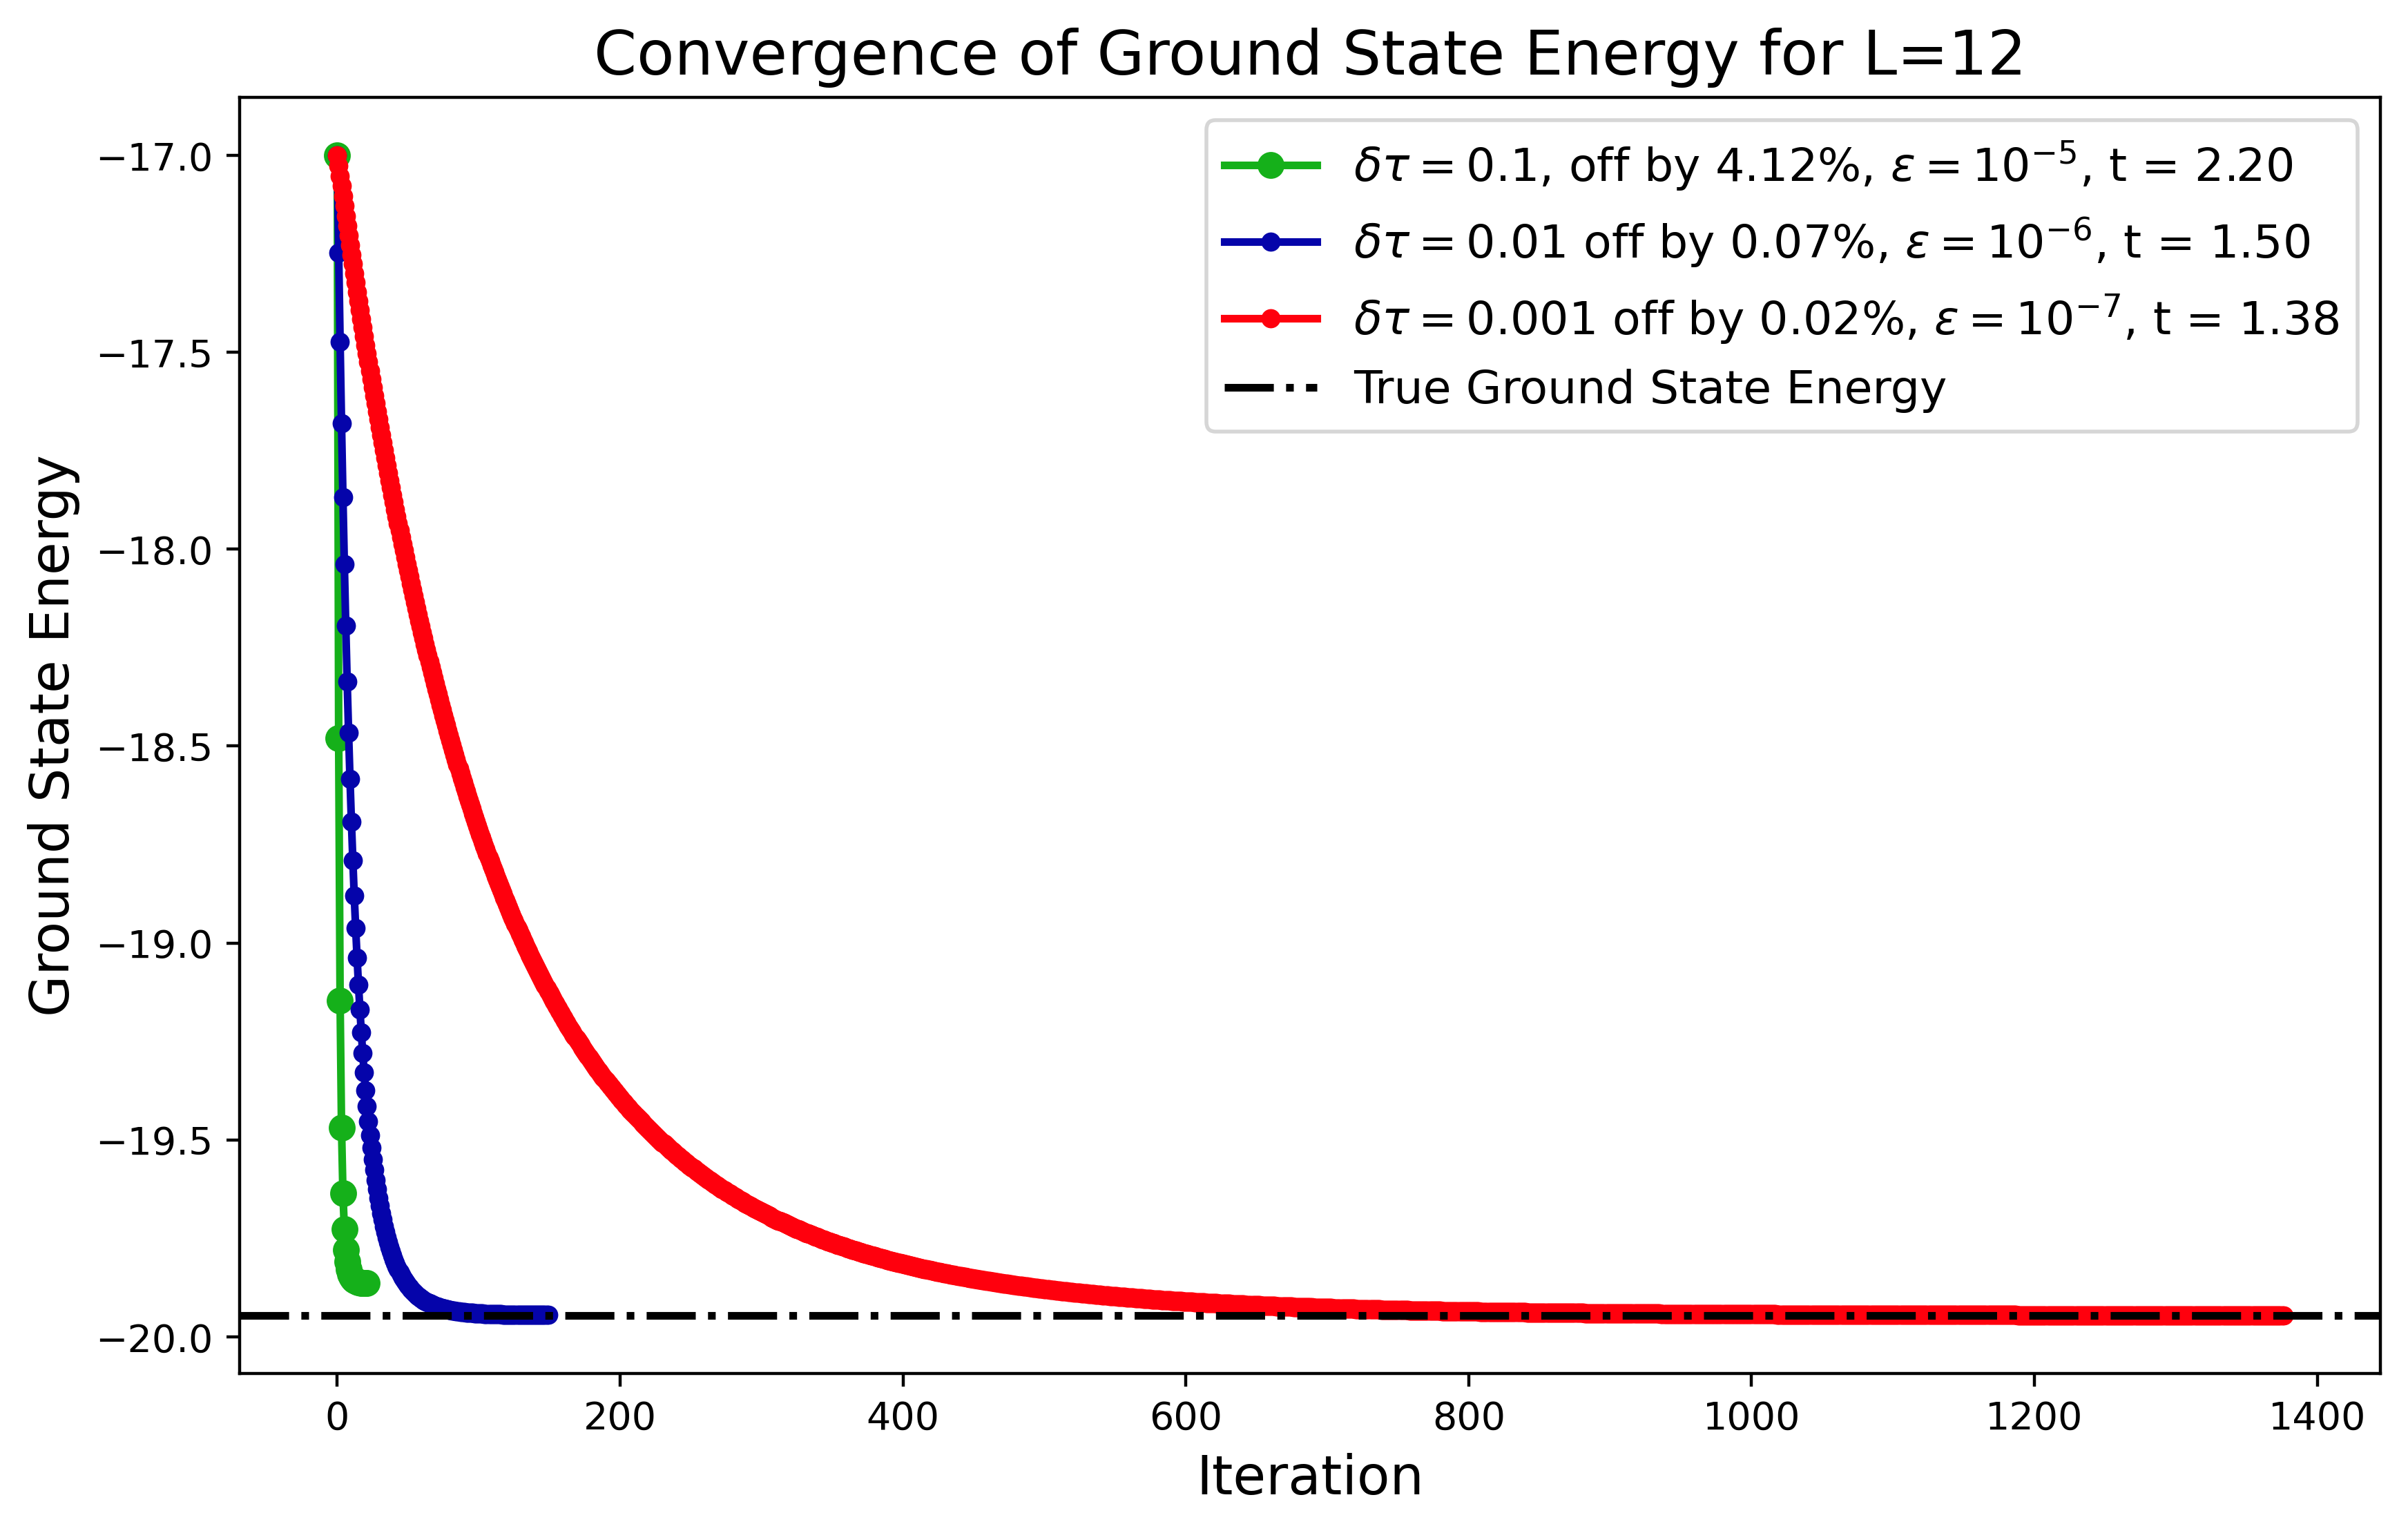

In [61]:
plt.figure(figsize=(10, 6))

colors = ['xkcd:green', 'xkcd:royal blue', 'xkcd:bright red']

plt.plot(energies_01, label='$\delta\\tau=0.1$,'+ f' off by {convergence_01.real:.2f}%' + r', $\epsilon=10^{-5}$' + f', t = {len(energies_01)*0.1:.2f}', marker='o', color=colors[0],linewidth=2)
plt.plot(energies_001, label='$\delta\\tau=0.01$' + f' off by {convergence_001.real:.2f}%' + r', $\epsilon=10^{-6}$' + f', t = {len(energies_001)*0.01:.2f}', marker='o', color=colors[1], markersize=4, linewidth=2)
plt.plot(energies_0001, label='$\delta\\tau=0.001$' + f' off by {convergence_0001.real:.2f}%' + r', $\epsilon=10^{-7}$'+ f', t = {len(energies_0001)*0.001:.2f}', marker='o', color=colors[2], markersize=4, linewidth=2)
plt.axhline(true_energy, label='True Ground State Energy', linestyle='dashdot', color='black', linewidth=2)

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Ground State Energy', fontsize=14)
plt.title('Convergence of Ground State Energy for L=12', fontsize=16)

plt.legend(fontsize=12)
plt.savefig(os.path.join(directory, 'ferromagnetic_convergence.png'), dpi=400)
plt.show()

In [ ]:
ground_state_energy, evolved_ket, energies, canonical_tracker = ground_state(0.001, J, hx, hz, ket, chi, 1e-10, 100000)
print(ground_state_energy)


In [104]:
J = 1
hx = -1.05
hz = 0.5
periodic = False 
dt = 0.01
chi = 16

system_sizes = [4, 8, 16, 32, 45, 64, 100, 128]
energy_densities = []
x = 2

for L in system_sizes:
    
    ket = ferromagnetic_state_MPS(L-x)
    energy1, _, _, _ = ground_state(dt, J, hx, hz, ket, chi, 1e-6, max_iterations=2000)
    ket = ferromagnetic_state_MPS(L)
    energy2, evolved_ket, _, canonical_tracker = ground_state(dt, J, hx, hz, ket, chi, 1e-6, max_iterations=2000)
    energy_densities.append((energy2-energy1)/x)


Iterations:   7%|████▏                                                          | 134/2000 [05:19<1:14:09,  2.38s/step]


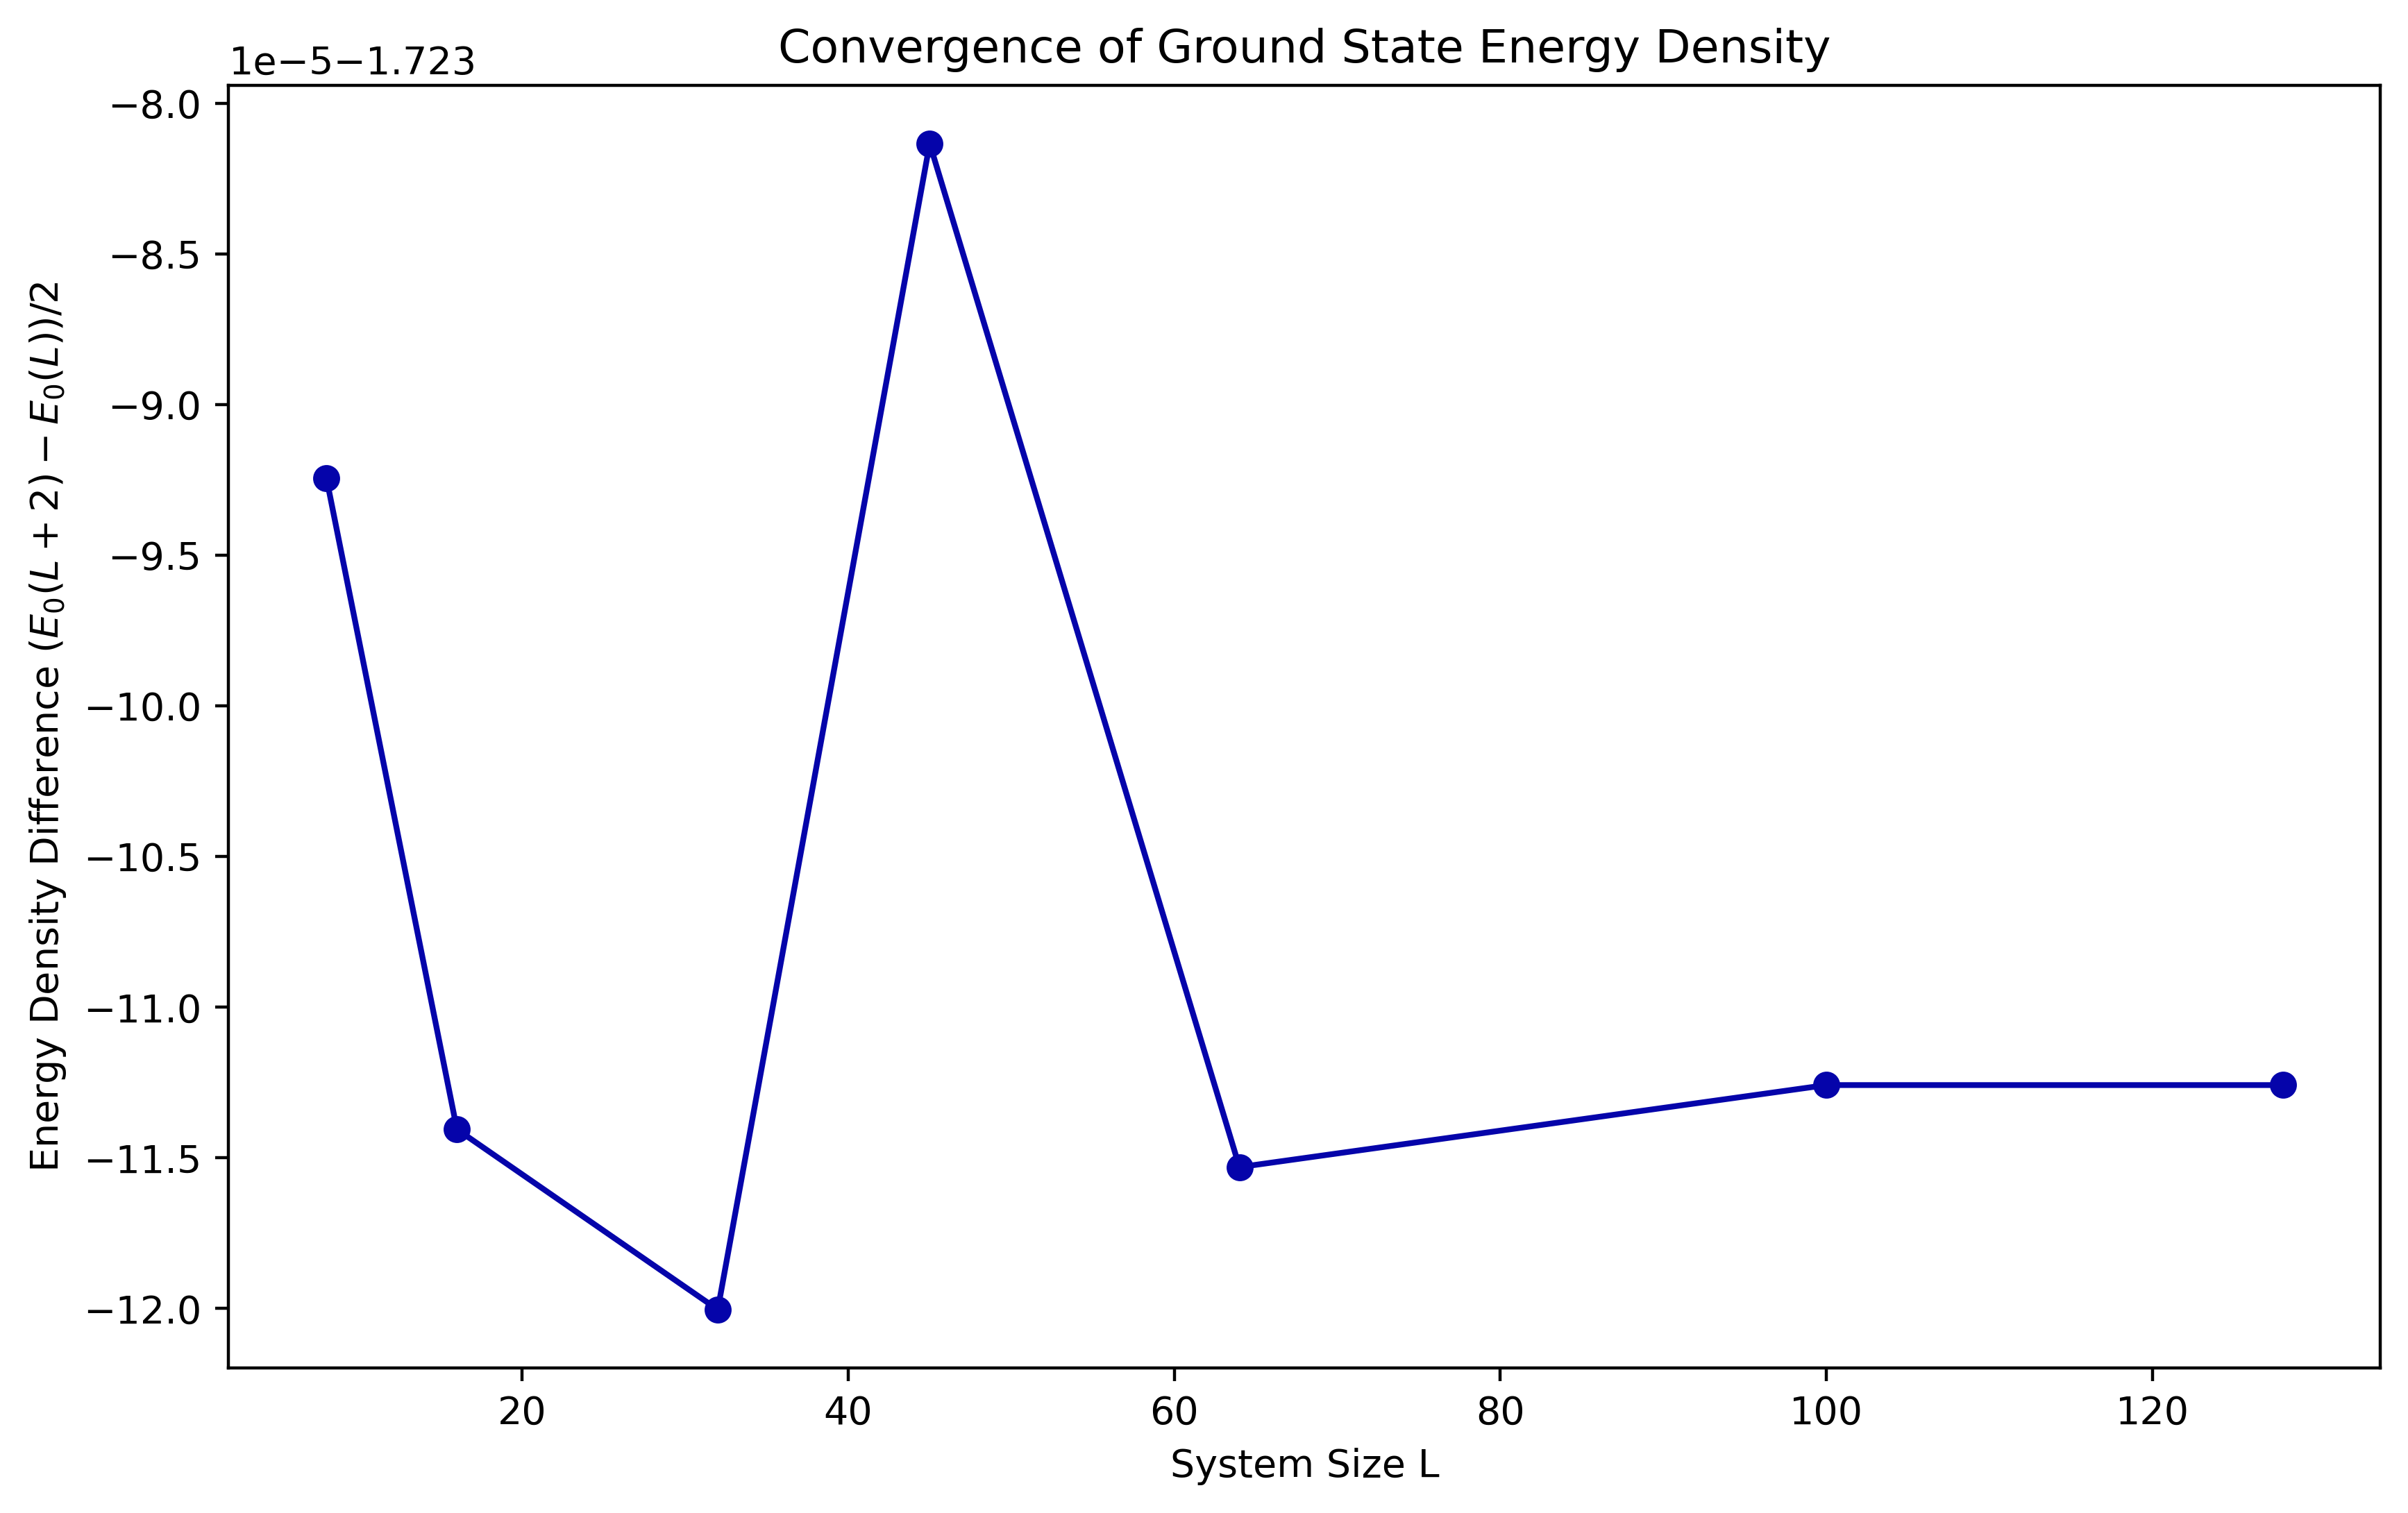

In [108]:
plt.figure(figsize=(10, 6))
plt.plot(system_sizes[1:], energy_densities[1:], marker='o', color='xkcd:royal blue')
plt.xlabel('System Size L')
plt.ylabel(r'Energy Density Difference $(E_0(L+2)-E_0(L))/2$')
plt.title('Convergence of Ground State Energy Density')
plt.savefig(os.path.join(directory, 'density_convergence.png'), dpi=400)
plt.show()


In [163]:
def expectation_value_Czz(r, evolved_ket, canonical_tracker):

    
    S = np.diag(canonical_tracker[2][1])

    ket = [np.copy(k) for k in evolved_ket]

    Z = np.array([[1,0],[0,-1]])
    
    Czzket = [np.copy(k) for k in ket]
    
    Czzket[0] = np.einsum('ij,kim->kjm', Z, Czzket[0])
    Czzket[r] =np.einsum('ij,kim->kjm', Z, Czzket[r])
    
    return inner_product(ket, Czzket)/(inner_product(ket, ket))
    

In [200]:
L = 128
J = 1
hx = -1.05
hz = 0.5
periodic = False 
dt = 0.1
chi = 16


ket = ferromagnetic_state_MPS(L)
ground_state_energy, evolved_ket, energies, canonical_tracker = ground_state(0.01, J, hx, hz, ket, chi, 1e-6,max_iterations=2000)


Iterations:   7%|████▏                                                          | 134/2000 [05:30<1:16:41,  2.47s/step]


Computing Correlators: 100%|█████████████████████████████████████████████████████████| 127/127 [00:36<00:00,  3.45it/s]


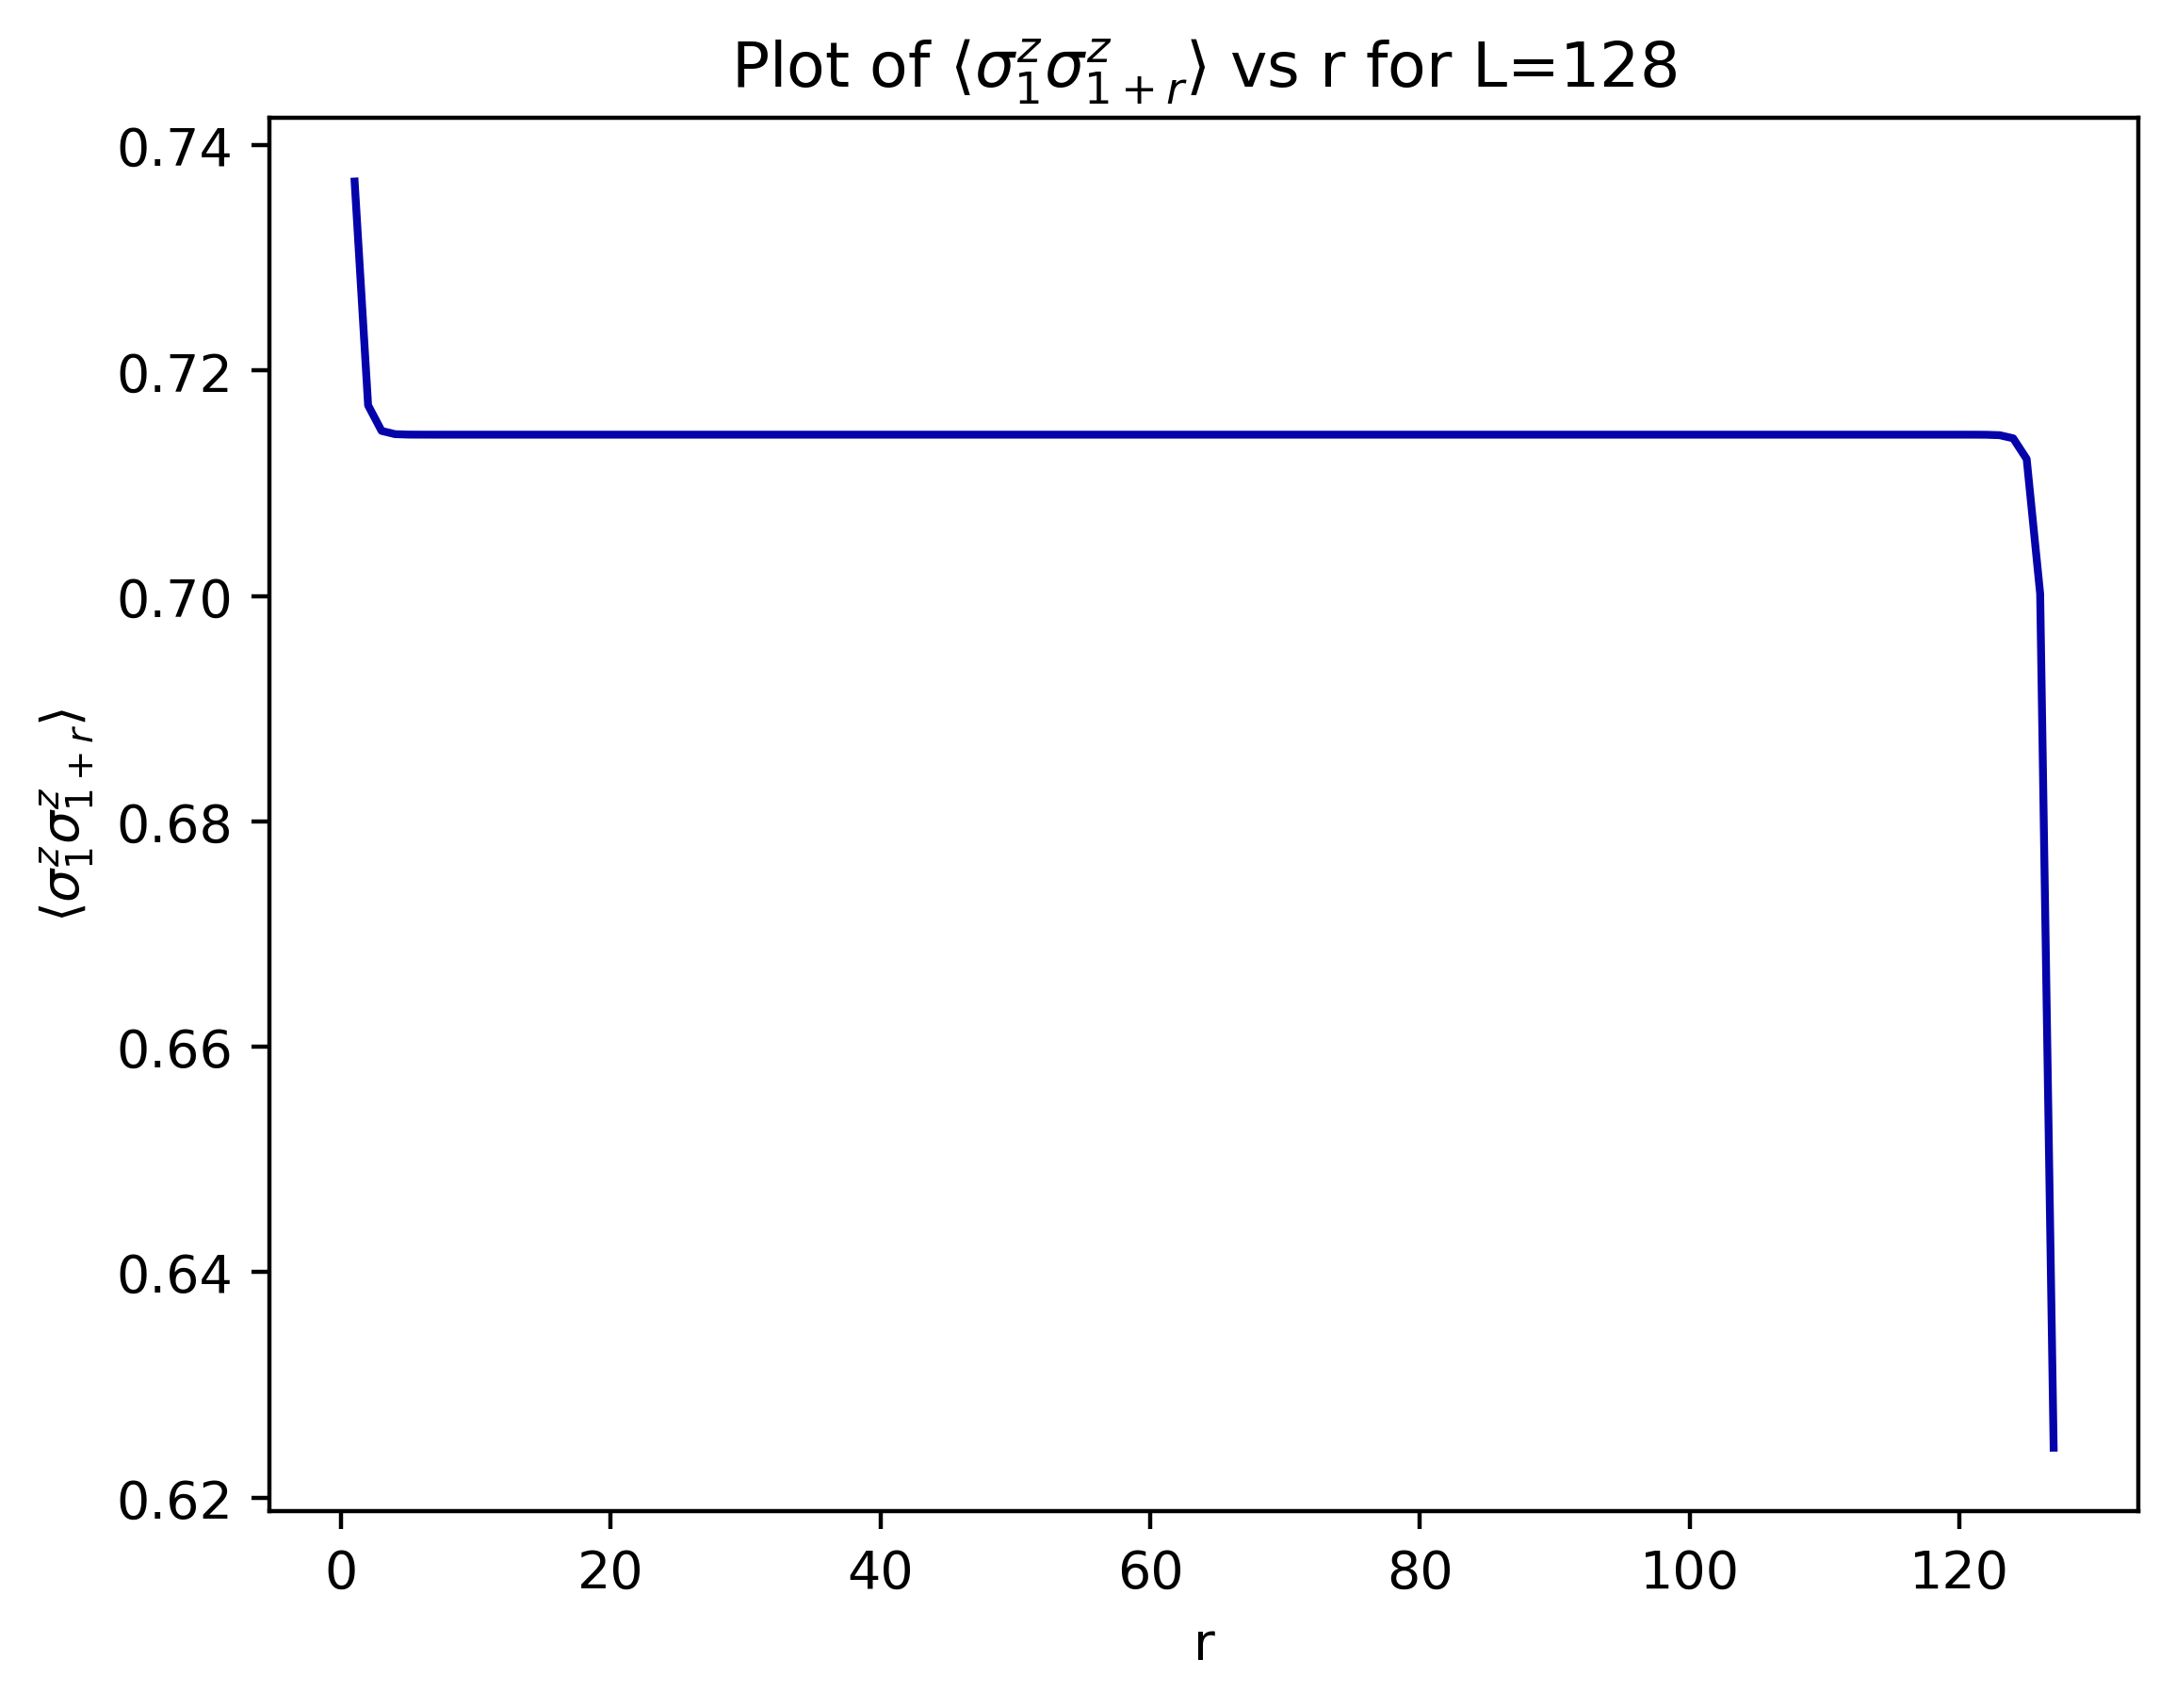

In [201]:
L = len(evolved_ket)
correlators = []
for r in tqdm(range(1, L), desc='Computing Correlators'):
    correlators.append(expectation_value_Czz(r, evolved_ket, canonical_tracker))

Rs=np.arange(1, L, 1)
plt.plot(Rs, correlators, color='xkcd:royal blue')
plt.xlabel('r')
plt.ylabel(r'$\langle\sigma^z_1\sigma^z_{1+r}\rangle$')
plt.title(r'Plot of $\langle\sigma^z_1\sigma^z_{1+r}\rangle$ vs r for L=128')
plt.savefig(os.path.join(directory, 'correlatorsp1.png'), dpi=400)
plt.show()

Computing Correlators: 100%|███████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.42it/s]


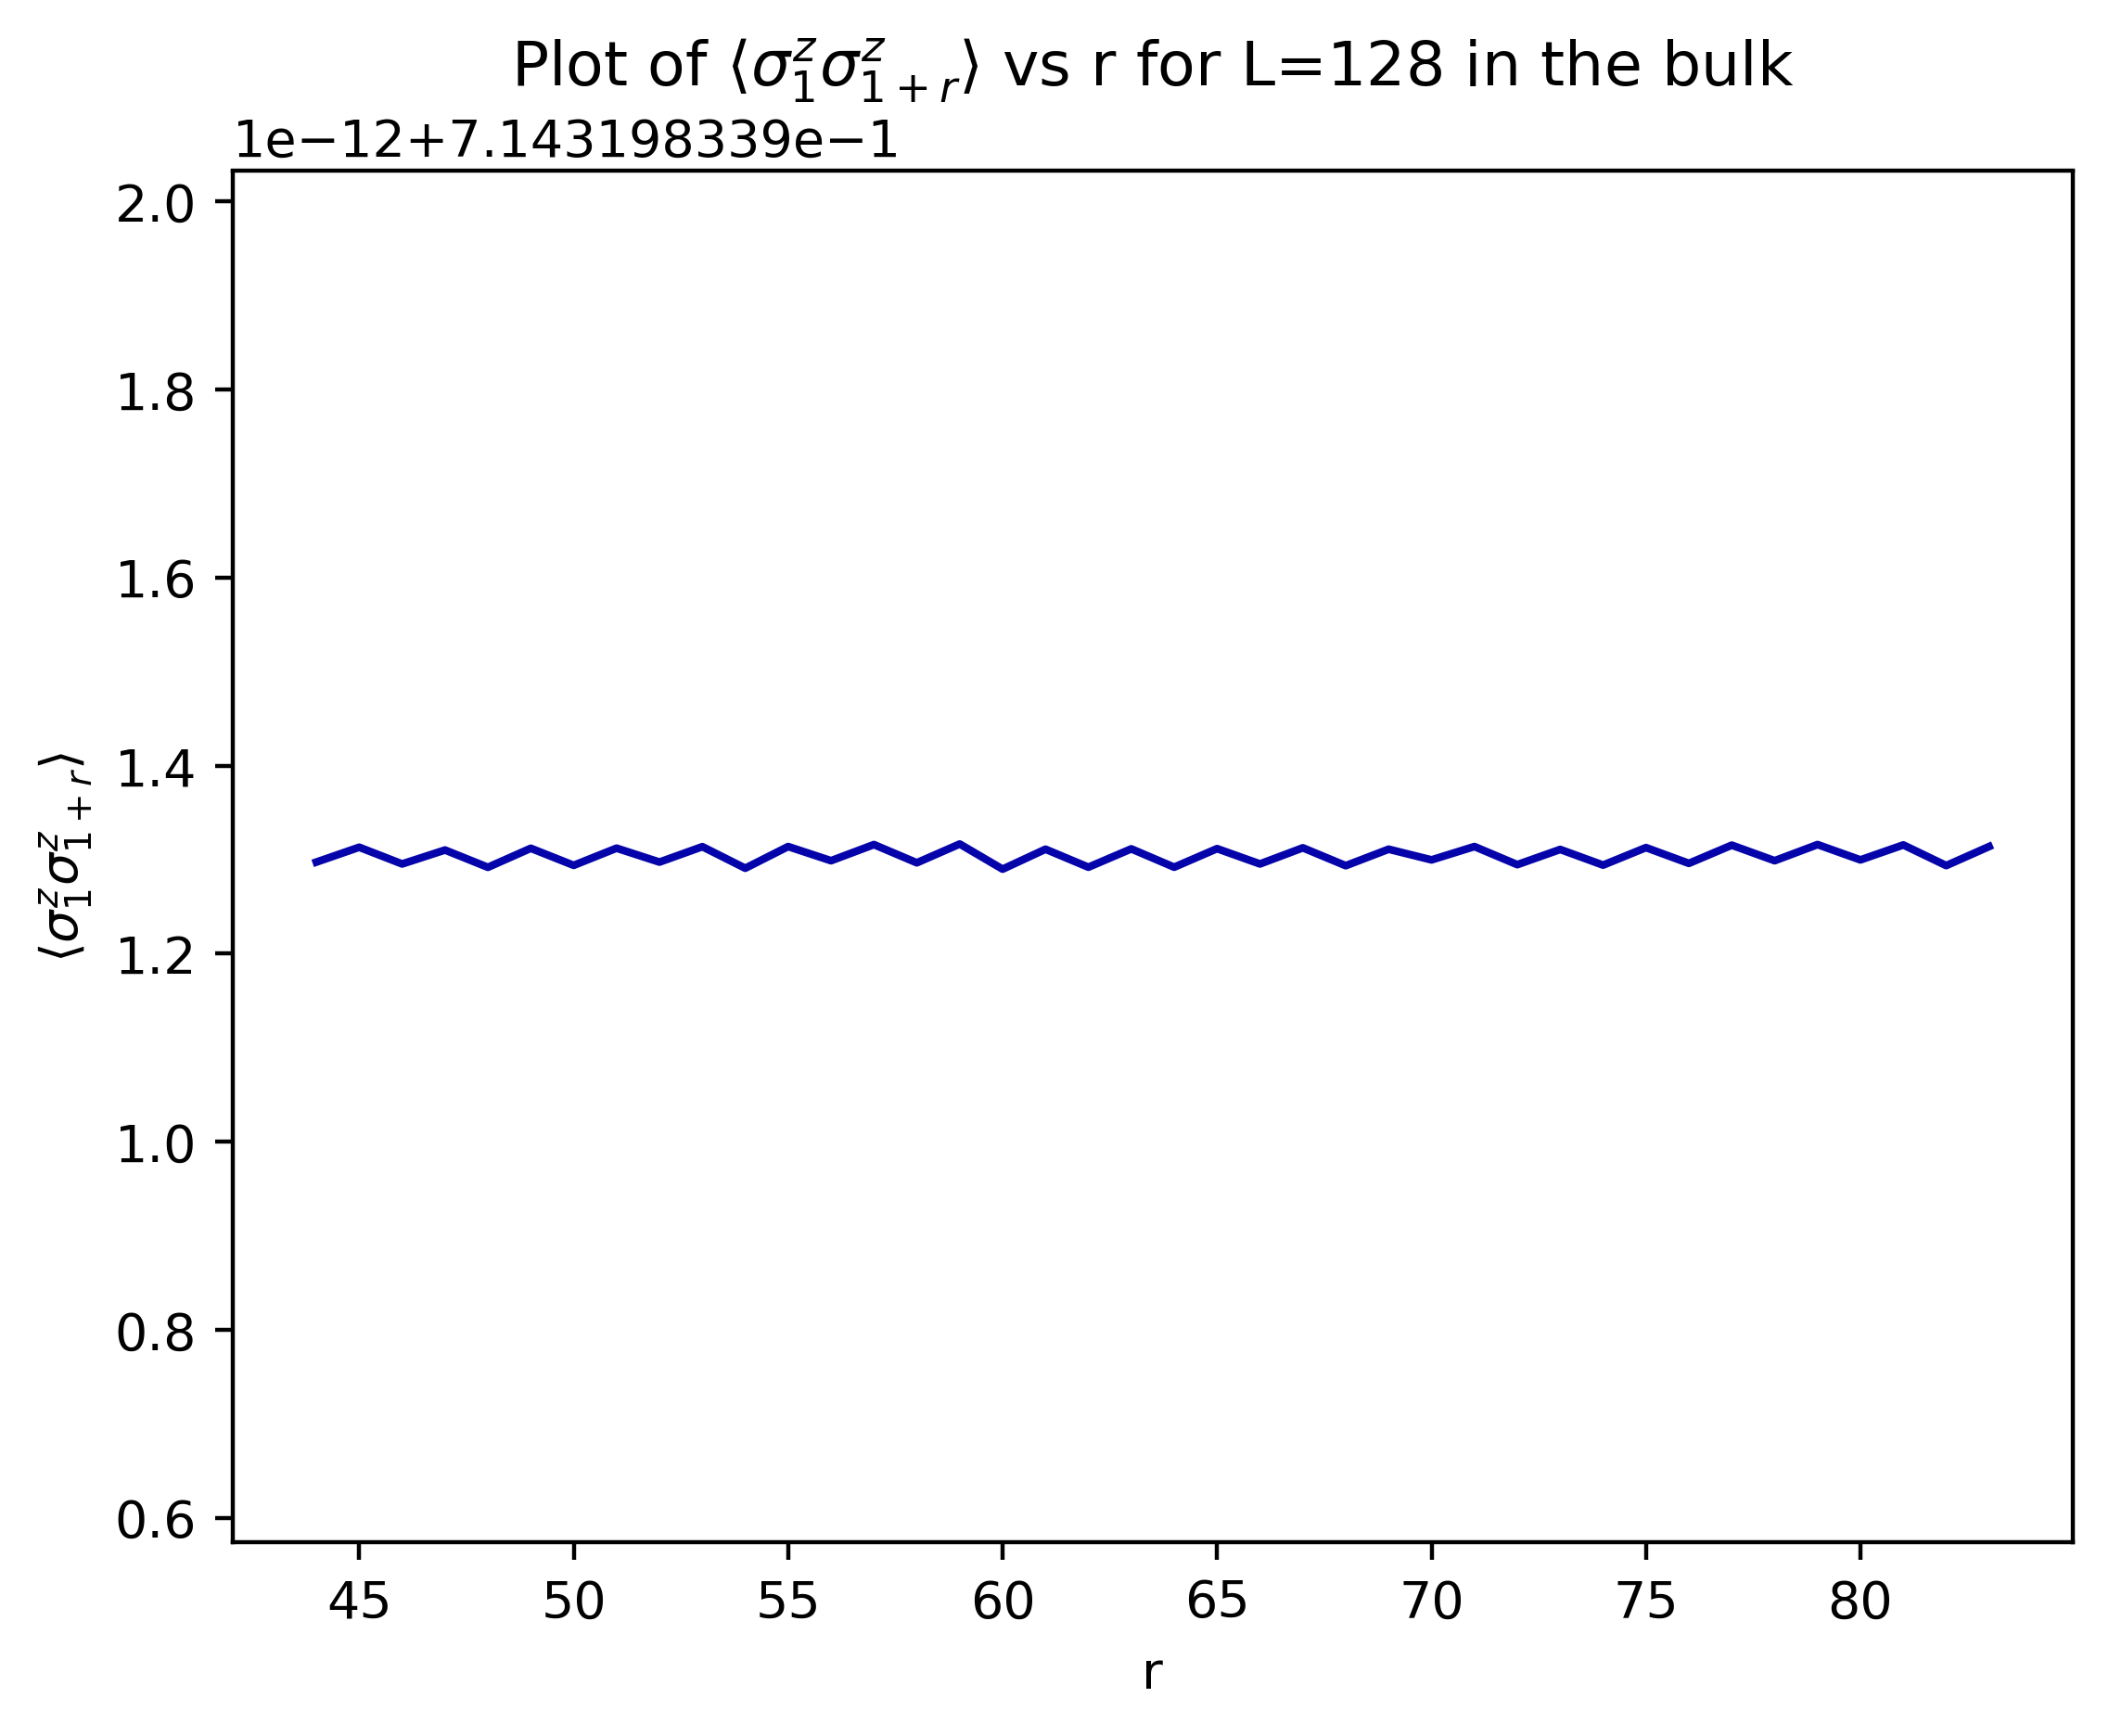

In [202]:
L = len(evolved_ket)
correlators = []
Rs=[]
for r in tqdm(range(L//2-20, L//2+20), desc='Computing Correlators'):
    correlators.append(expectation_value_Czz(r, evolved_ket, canonical_tracker))
    Rs.append(r)

plt.plot(Rs, correlators, color='xkcd:royal blue')
plt.xlabel('r')
plt.ylabel(r'$\langle\sigma^z_1\sigma^z_{1+r}\rangle$')
plt.title(r'Plot of $\langle\sigma^z_1\sigma^z_{1+r}\rangle$ vs r for L=128 in the bulk')
plt.savefig(os.path.join(directory, 'correlatorsp1zoomedin.png'), dpi=400)
plt.show() 

## Neel wave function

In [192]:
def neel_state_MPS(L):
    
    # given L, returns the MPS tensors of the ferromagnetic state.
    
    mps_tensors= []
    
    Aeven = np.zeros((1, 2, 1), dtype = complex)
    Aeven[0, 0, 0] = 1
    Aeven[0, 1, 0] = 0

    Aodd = np.zeros((1, 2, 1), dtype = complex)
    Aodd[0, 0, 0] = 0
    Aodd[0, 1, 0] = 1
    
    for i in range(L):
        if i%2 == 0:
            mps_tensors.append(Aodd)
        if i%2 != 0:
            mps_tensors.append(Aeven)

    return mps_tensors

In [243]:
L = 128
J = 1
hx = -1.05
hz = 0.5
periodic = False 
dt = 0.1
chi = 16

ket = neel_state_MPS(L)
# ground_state_energy, evolved_ket, energies_01, canonical_tracker = ground_state(0.1, J, hx, hz, ket, chi, 1e-5, max_iterations=3000)
# print(ground_state_energy)


ground_state_energy, evolved_ket, energies_001, canonical_trackers = ground_state(0.01, J, hx, hz, ket, chi, 1e-6,max_iterations=3000)
print(ground_state_energy)

# ground_state_energy, evolved_ket, energies_0001, canonical_tracker = ground_state(0.001, J, hx, hz, ket, chi, 1e-7, max_iterations=3000)
# print(ground_state_energy)


Iterations:   6%|███▌                                                           | 167/3000 [07:10<2:01:37,  2.58s/step]

(-219.8321369316661+0j)


In [244]:
L = 128
J = 1
hx = -1.05
hz = 0.5
periodic = False 
dt = 0.1
chi = 16

ket = ferromagnetic_state_MPS(L)

ground_state_energy_ferro, evolved_ket_ferro, energies_001_ferro, canonical_trackers_ferro = ground_state(0.01, J, hx, hz, ket, chi, 1e-6,max_iterations=3000)
print(ground_state_energy)

# ground_state_energy, evolved_ket, energies_0001, canonical_tracker = ground_state(0.001, J, hx, hz, ket, chi, 1e-7, max_iterations=3000)
# print(ground_state_energy)


Iterations:   4%|██▊                                                            | 134/3000 [05:46<2:03:20,  2.58s/step]

(-219.8321369316661+0j)


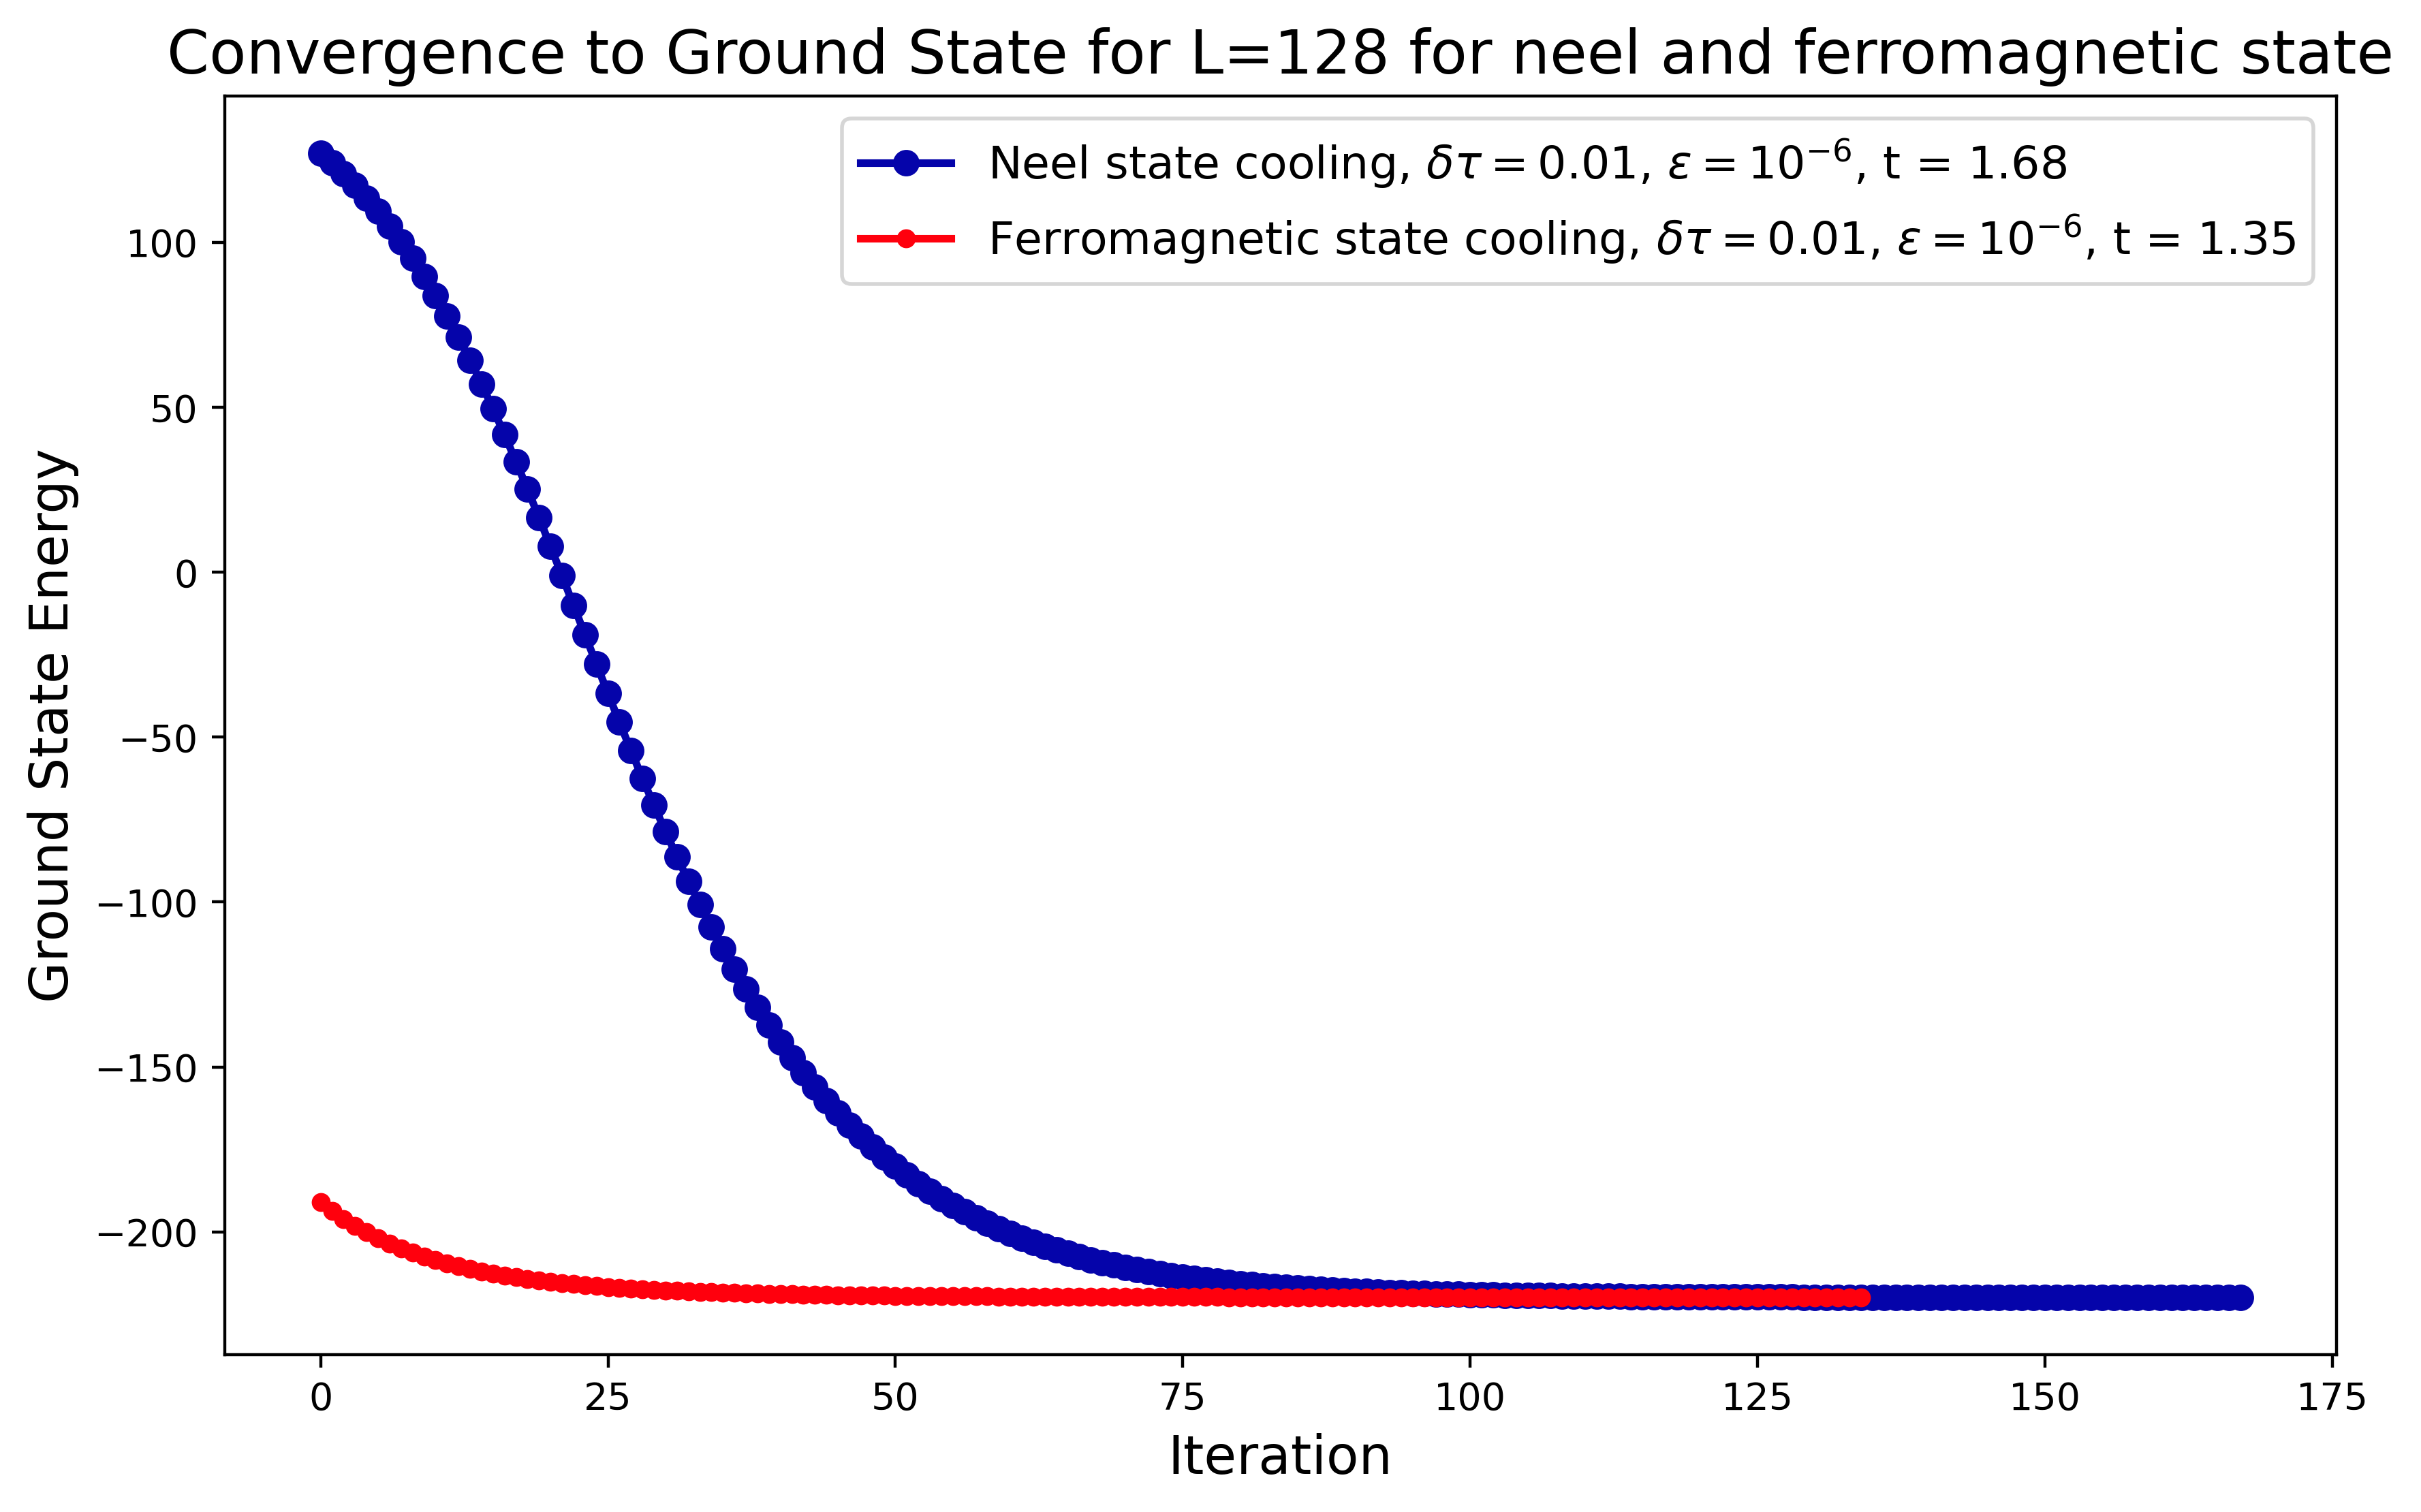

In [225]:
plt.figure(figsize=(10, 6))

colors = ['xkcd:green', 'xkcd:royal blue', 'xkcd:bright red']

plt.plot(energies_001, label='Neel state cooling, $\delta\\tau=0.01$' + r', $\epsilon=10^{-6}$' + f', t = {len(energies_001)*0.01:.2f}', marker='o', color=colors[1],linewidth=2)
plt.plot(energies_001_ferro, label='Ferromagnetic state cooling, $\delta\\tau=0.01$' +  r', $\epsilon=10^{-6}$' + f', t = {len(energies_001_ferro)*0.01:.2f}', marker='o', color=colors[2], markersize=4, linewidth=2)

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Ground State Energy', fontsize=14)
plt.title('Convergence to Ground State for L=128 for neel and ferromagnetic state', fontsize=16)

plt.legend(fontsize=12)
plt.savefig(os.path.join(directory, 'neel_ferro_convergence.png'), dpi=400)
plt.show()

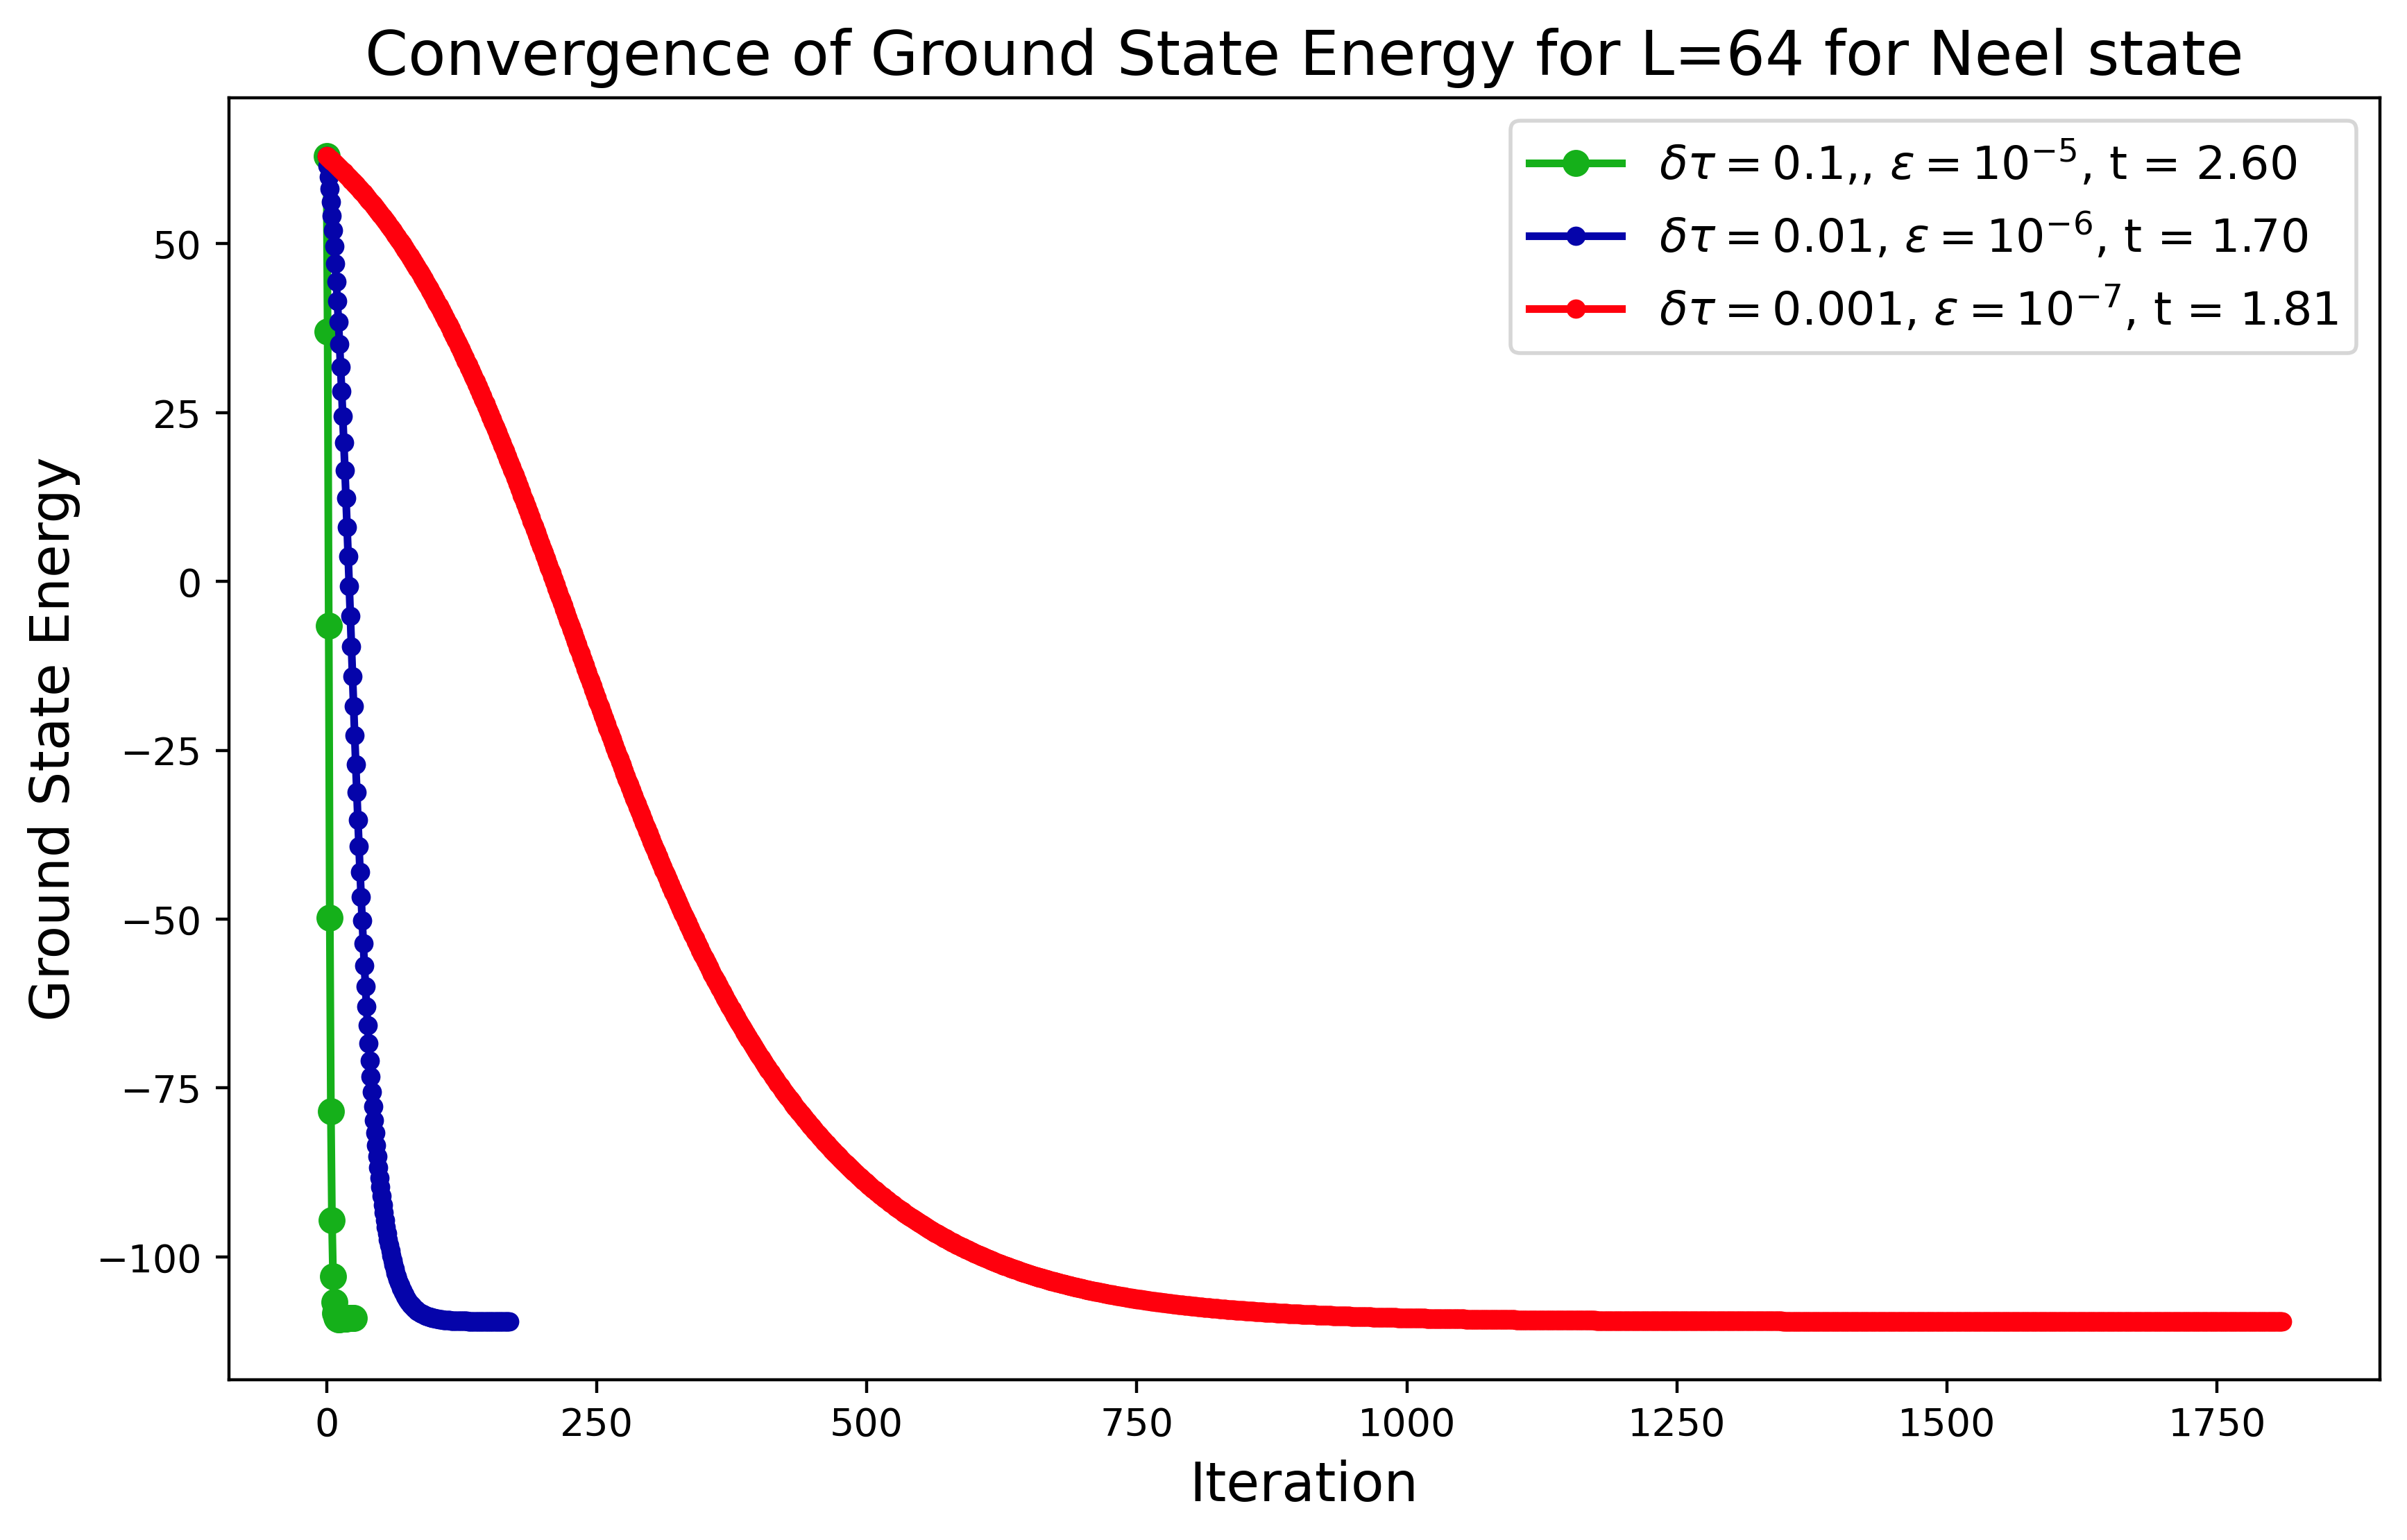

In [210]:
plt.figure(figsize=(10, 6))

colors = ['xkcd:green', 'xkcd:royal blue', 'xkcd:bright red']

plt.plot(energies_01, label='$\delta\\tau=0.1$' + r', $\epsilon=10^{-5}$' + f', t = {len(energies_01)*0.1:.2f}', marker='o', color=colors[0],linewidth=2)
plt.plot(energies_001, label='$\delta\\tau=0.01$' +  r', $\epsilon=10^{-6}$' + f', t = {len(energies_001)*0.01:.2f}', marker='o', color=colors[1], markersize=4, linewidth=2)
plt.plot(energies_0001, label='$\delta\\tau=0.001$' + r', $\epsilon=10^{-7}$'+ f', t = {len(energies_0001)*0.001:.2f}', marker='o', color=colors[2], markersize=4, linewidth=2)

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Ground State Energy', fontsize=14)
plt.title('Convergence of Ground State Energy for L=64 for Neel state', fontsize=16)

plt.legend(fontsize=12)
plt.savefig(os.path.join(directory, 'neel_convergence.png'), dpi=400)
plt.show()

Computing Correlators: 100%|█████████████████████████████████████████████████████████| 127/127 [00:37<00:00,  3.43it/s]


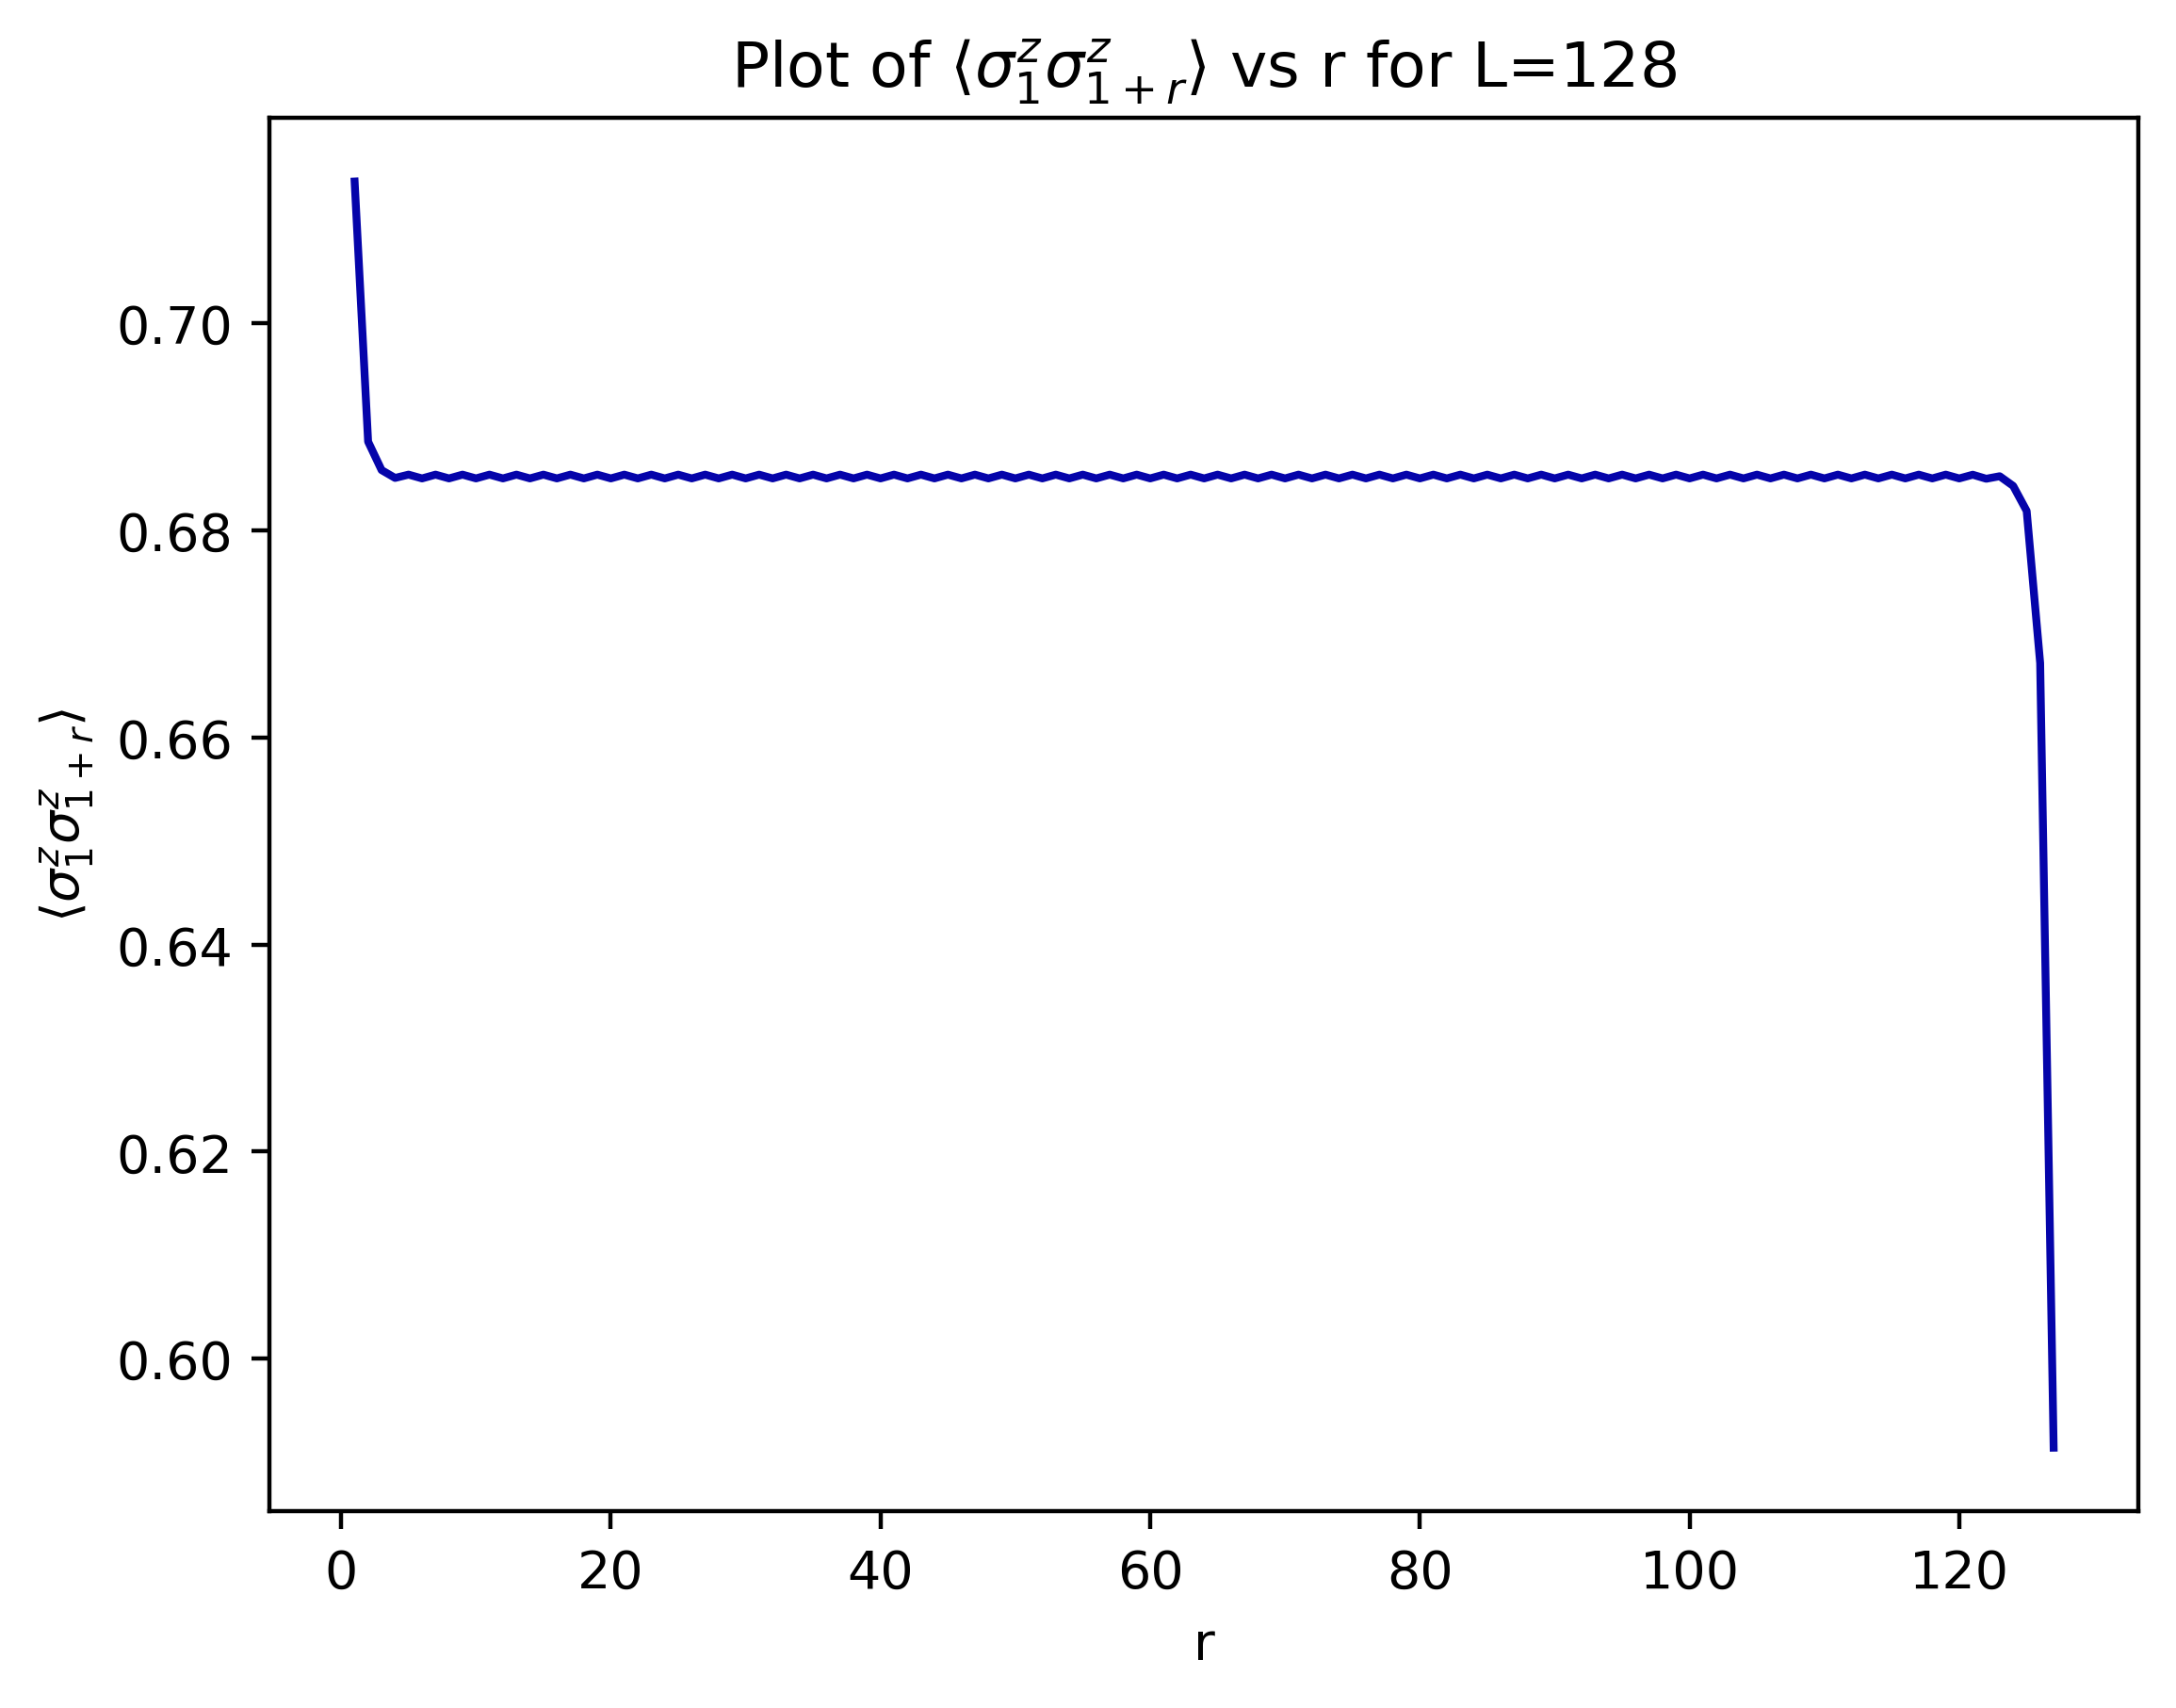

In [219]:
L = len(evolved_ket)
correlators = []
for r in tqdm(range(1, L), desc='Computing Correlators'):
    correlators.append(expectation_value_Czz(r, evolved_ket, canonical_tracker))

Rs=np.arange(1, L, 1)
plt.plot(Rs, correlators, color='xkcd:royal blue')
plt.xlabel('r')
plt.ylabel(r'$\langle\sigma^z_1\sigma^z_{1+r}\rangle$')
plt.title(r'Plot of $\langle\sigma^z_1\sigma^z_{1+r}\rangle$ vs r for L=128')
plt.savefig(os.path.join(directory, 'correlatorsp1neel.png'), dpi=400)
plt.show()

Computing Correlators: 100%|█████████████████████████████████████████████████████████| 127/127 [01:14<00:00,  1.69it/s]


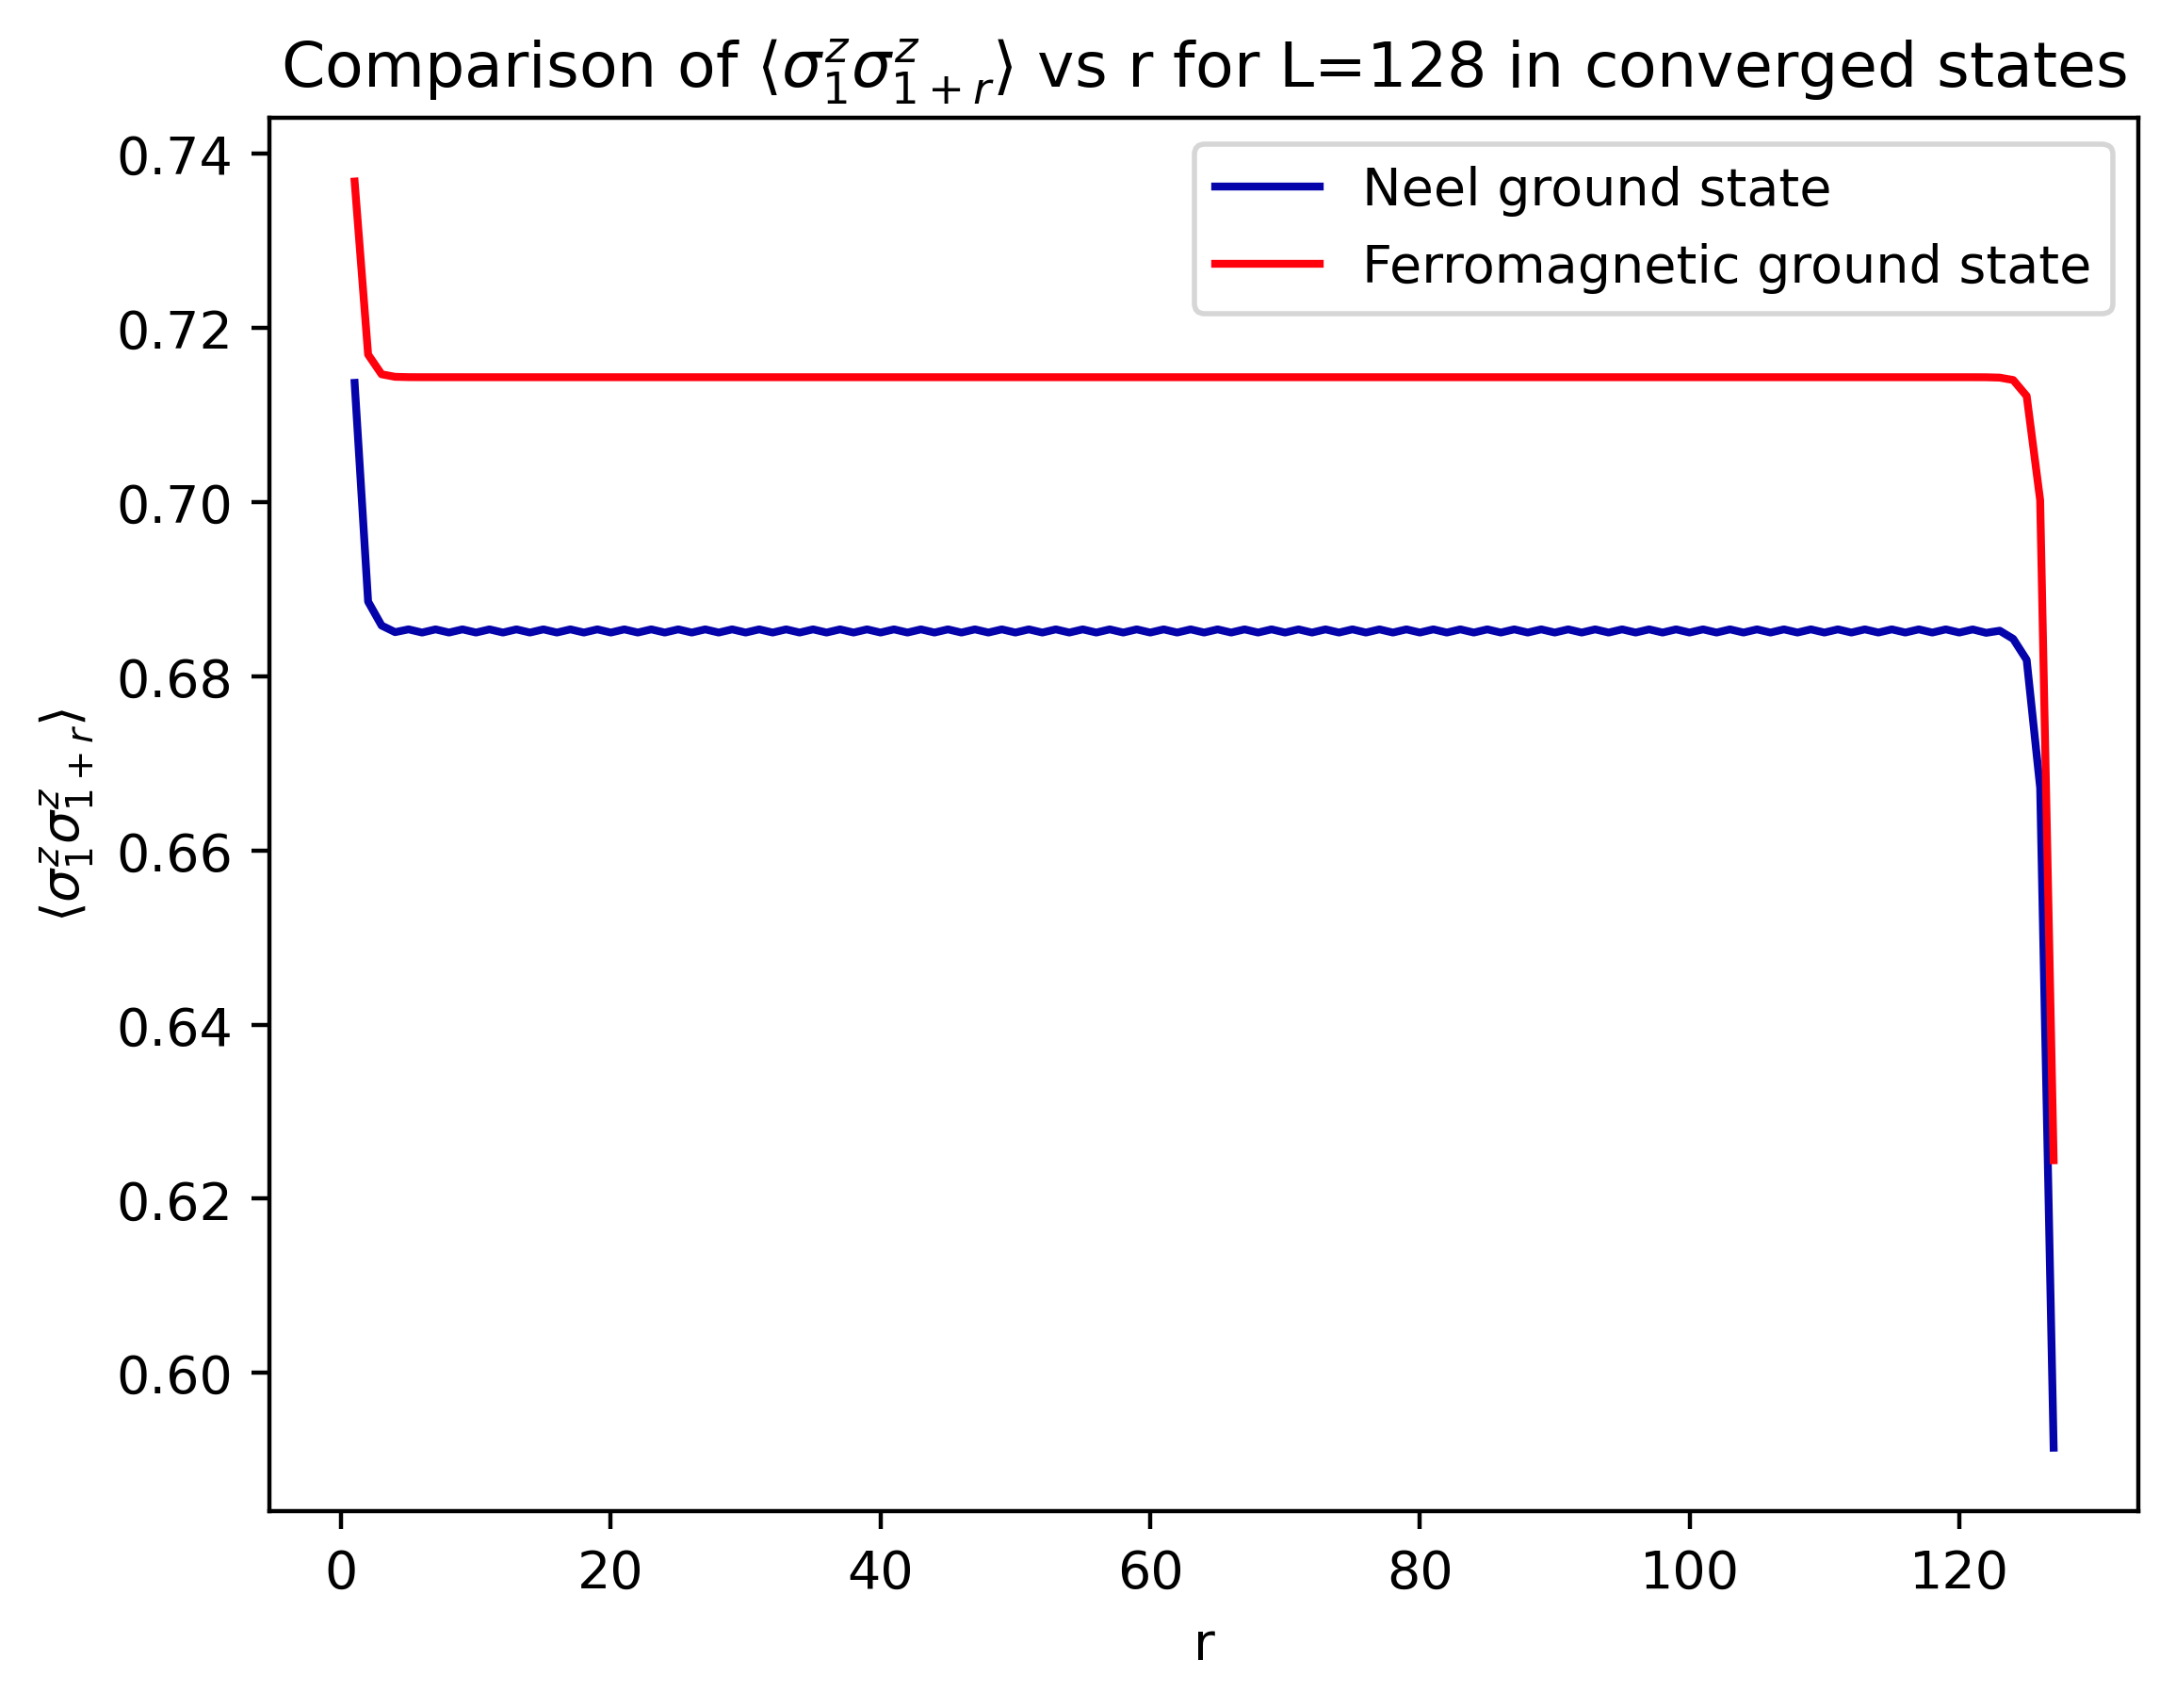

In [227]:
L = len(evolved_ket)
correlators_ferro = []
correlators = []
for r in tqdm(range(1, L), desc='Computing Correlators'):
    correlators.append(expectation_value_Czz(r, evolved_ket, canonical_tracker))
    correlators_ferro.append(expectation_value_Czz(r, evolved_ket_ferro, canonical_tracker_ferro))

Rs=np.arange(1, L, 1)
plt.plot(Rs, correlators, color='xkcd:royal blue', label='Neel ground state')
plt.plot(Rs, correlators_ferro, color='xkcd:bright red', label='Ferromagnetic ground state')

plt.xlabel('r')
plt.ylabel(r'$\langle\sigma^z_1\sigma^z_{1+r}\rangle$')
plt.title(r'Comparison of $\langle\sigma^z_1\sigma^z_{1+r}\rangle$ vs r for L=128 in converged states')
plt.legend()
plt.savefig(os.path.join(directory, 'correlatorsp1neelvsferro.png'), dpi=400)
plt.show()

Computing Correlators: 100%|███████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.42it/s]


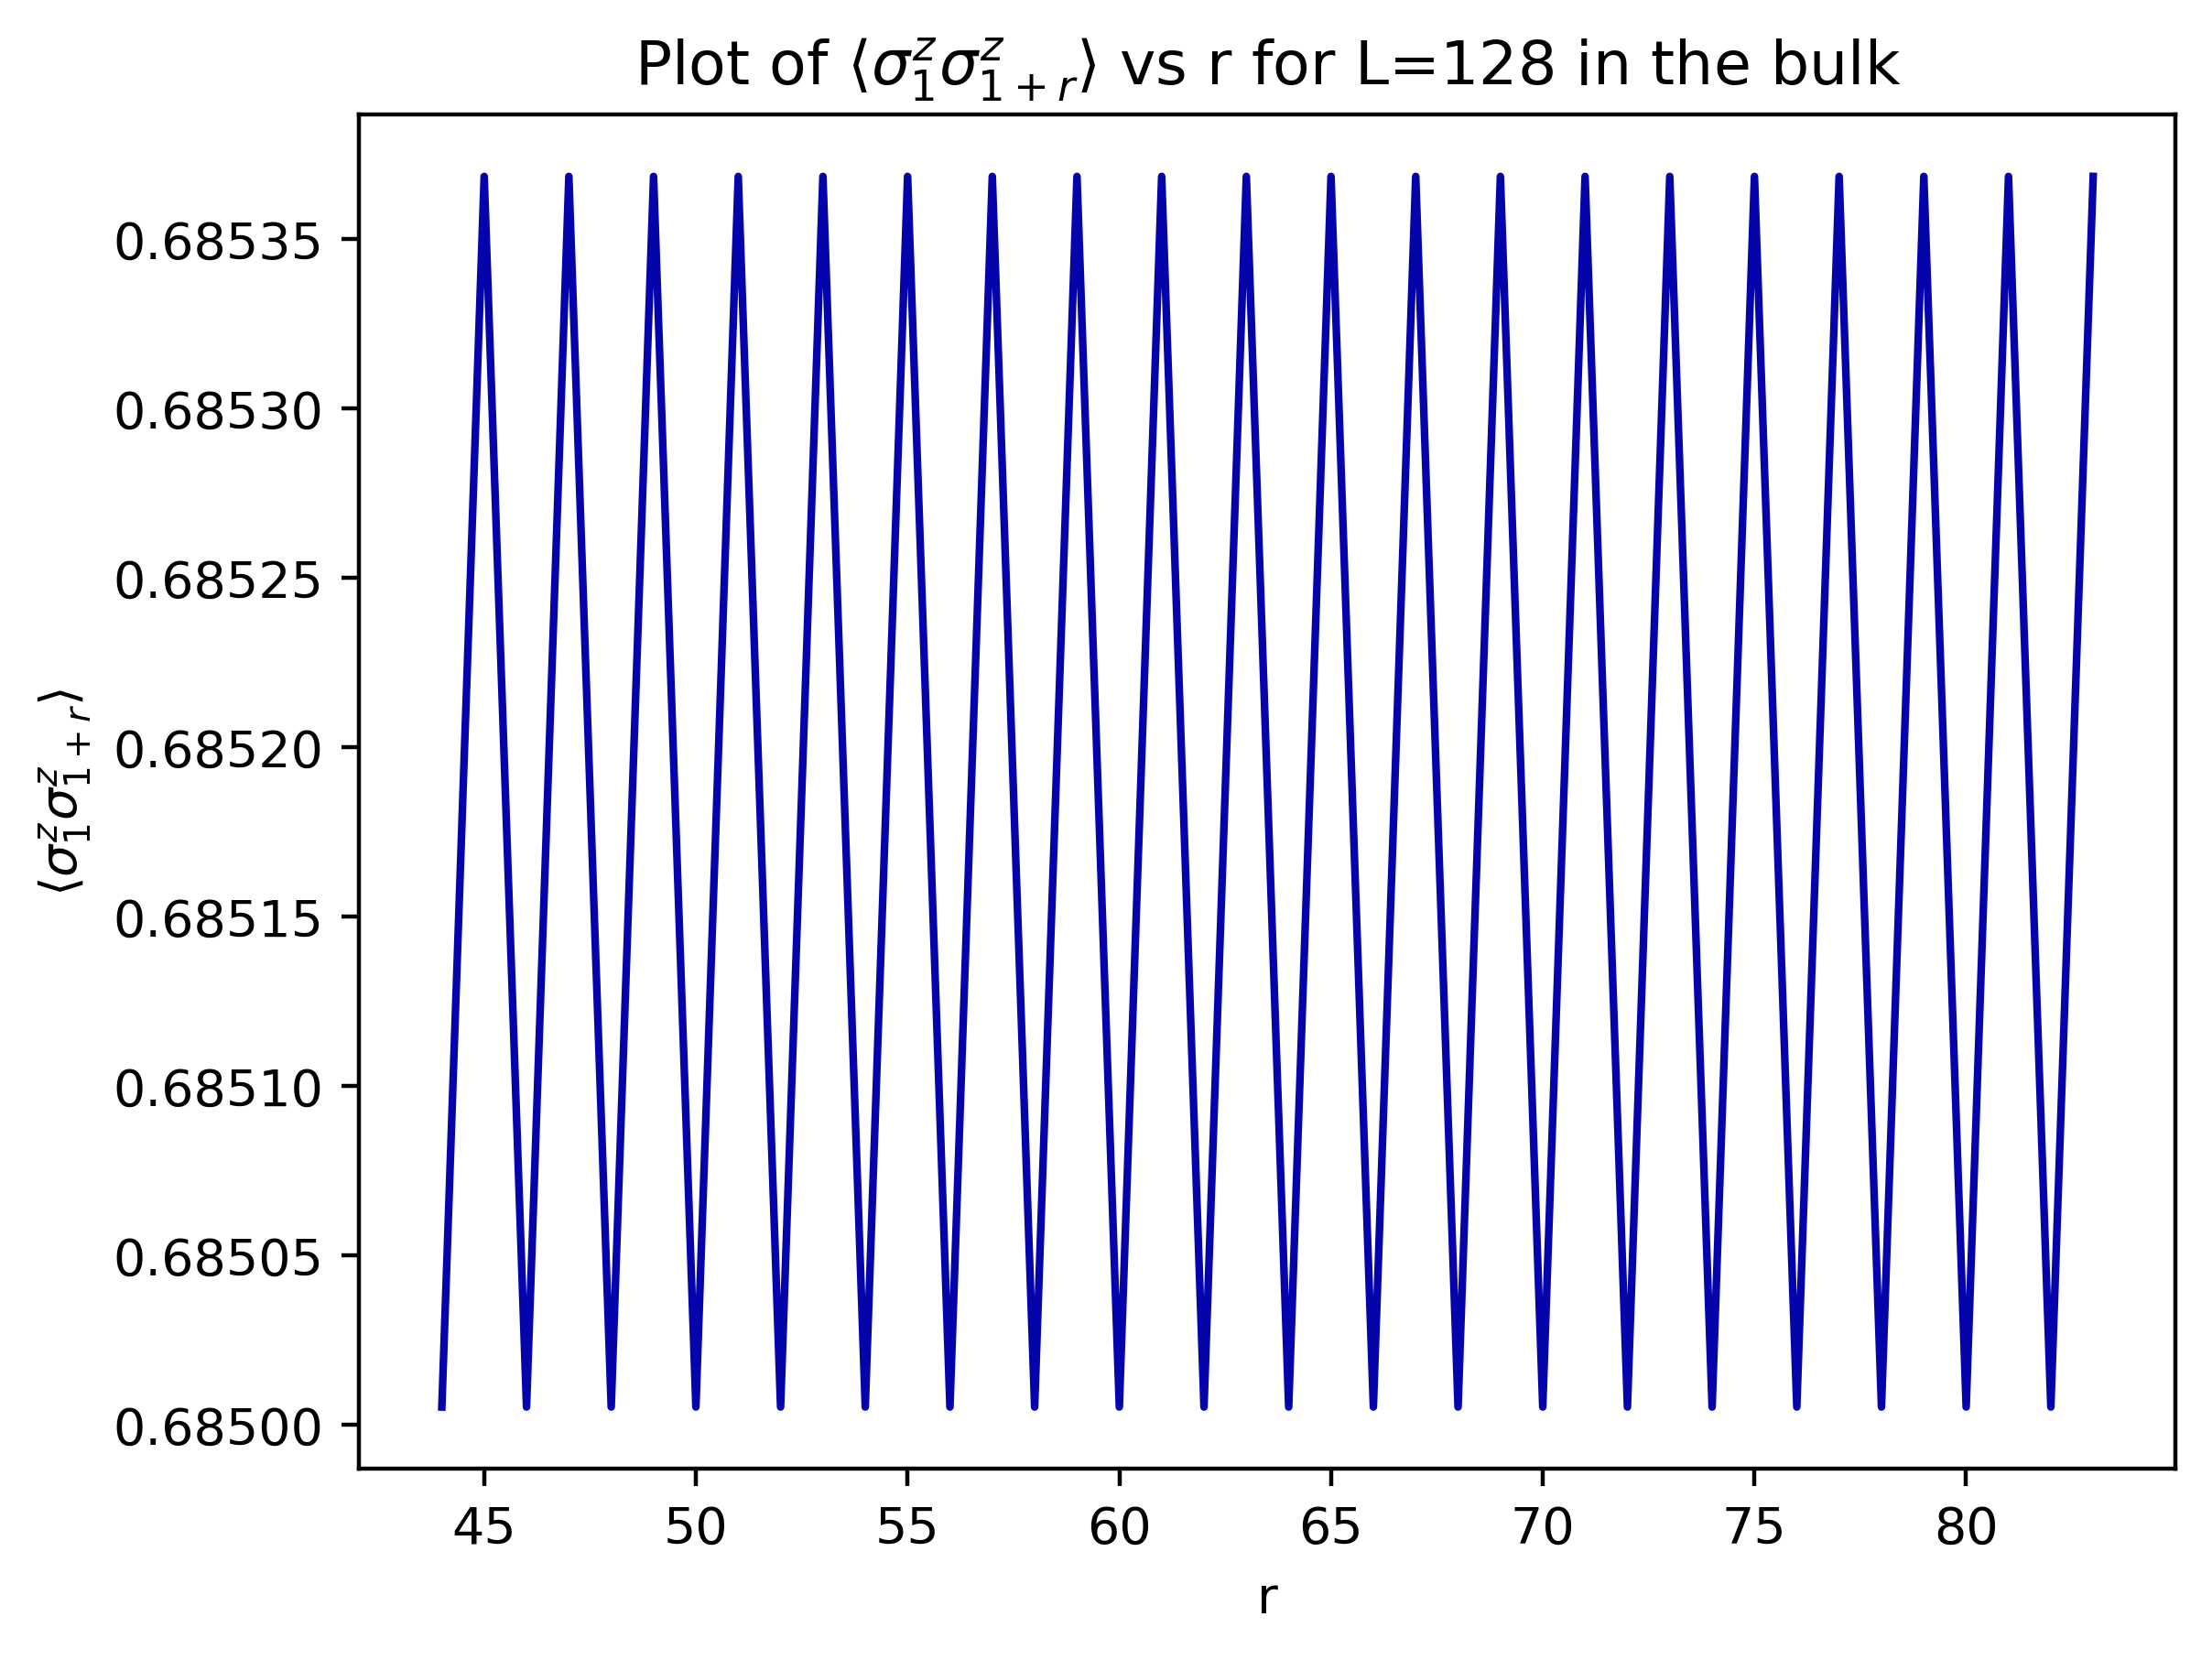

In [217]:
L = len(evolved_ket)
correlators = []
Rs=[]
for r in tqdm(range(L//2-20, L//2+20), desc='Computing Correlators'):
    correlators.append(expectation_value_Czz(r, evolved_ket, canonical_tracker))
    Rs.append(r)

plt.plot(Rs, correlators, color='xkcd:royal blue')
plt.xlabel('r')
plt.ylabel(r'$\langle\sigma^z_1\sigma^z_{1+r}\rangle$')
plt.title(r'Plot of $\langle\sigma^z_1\sigma^z_{1+r}\rangle$ vs r for L=128 in the bulk')
plt.savefig(os.path.join(directory, 'correlatorsp1zoomedin_neel.png'), dpi=400)
plt.show() 

In [218]:
def expectation_value_Cz(r, evolved_ket, canonical_tracker):

    
    S = np.diag(canonical_tracker[2][1])

    ket = [np.copy(k) for k in evolved_ket]

    Z = np.array([[1,0],[0,-1]])
    
    Czzket = [np.copy(k) for k in ket]
    
    Czzket[r] =np.einsum('ij,kim->kjm', Z, Czzket[r])
    
    return inner_product(ket, Czzket)/(inner_product(ket, ket))
    

In [231]:
L = len(evolved_ket)
correlators_ferro = []
correlators = []
for r in tqdm(range(L), desc='Computing Correlators'):
    correlators.append(expectation_value_Cz(r, evolved_ket, canonical_tracker))
    correlators_ferro.append(expectation_value_Cz(r, evolved_ket_ferro, canonical_tracker_ferro))


Computing Correlators: 100%|█████████████████████████████████████████████████████████| 128/128 [01:16<00:00,  1.68it/s]


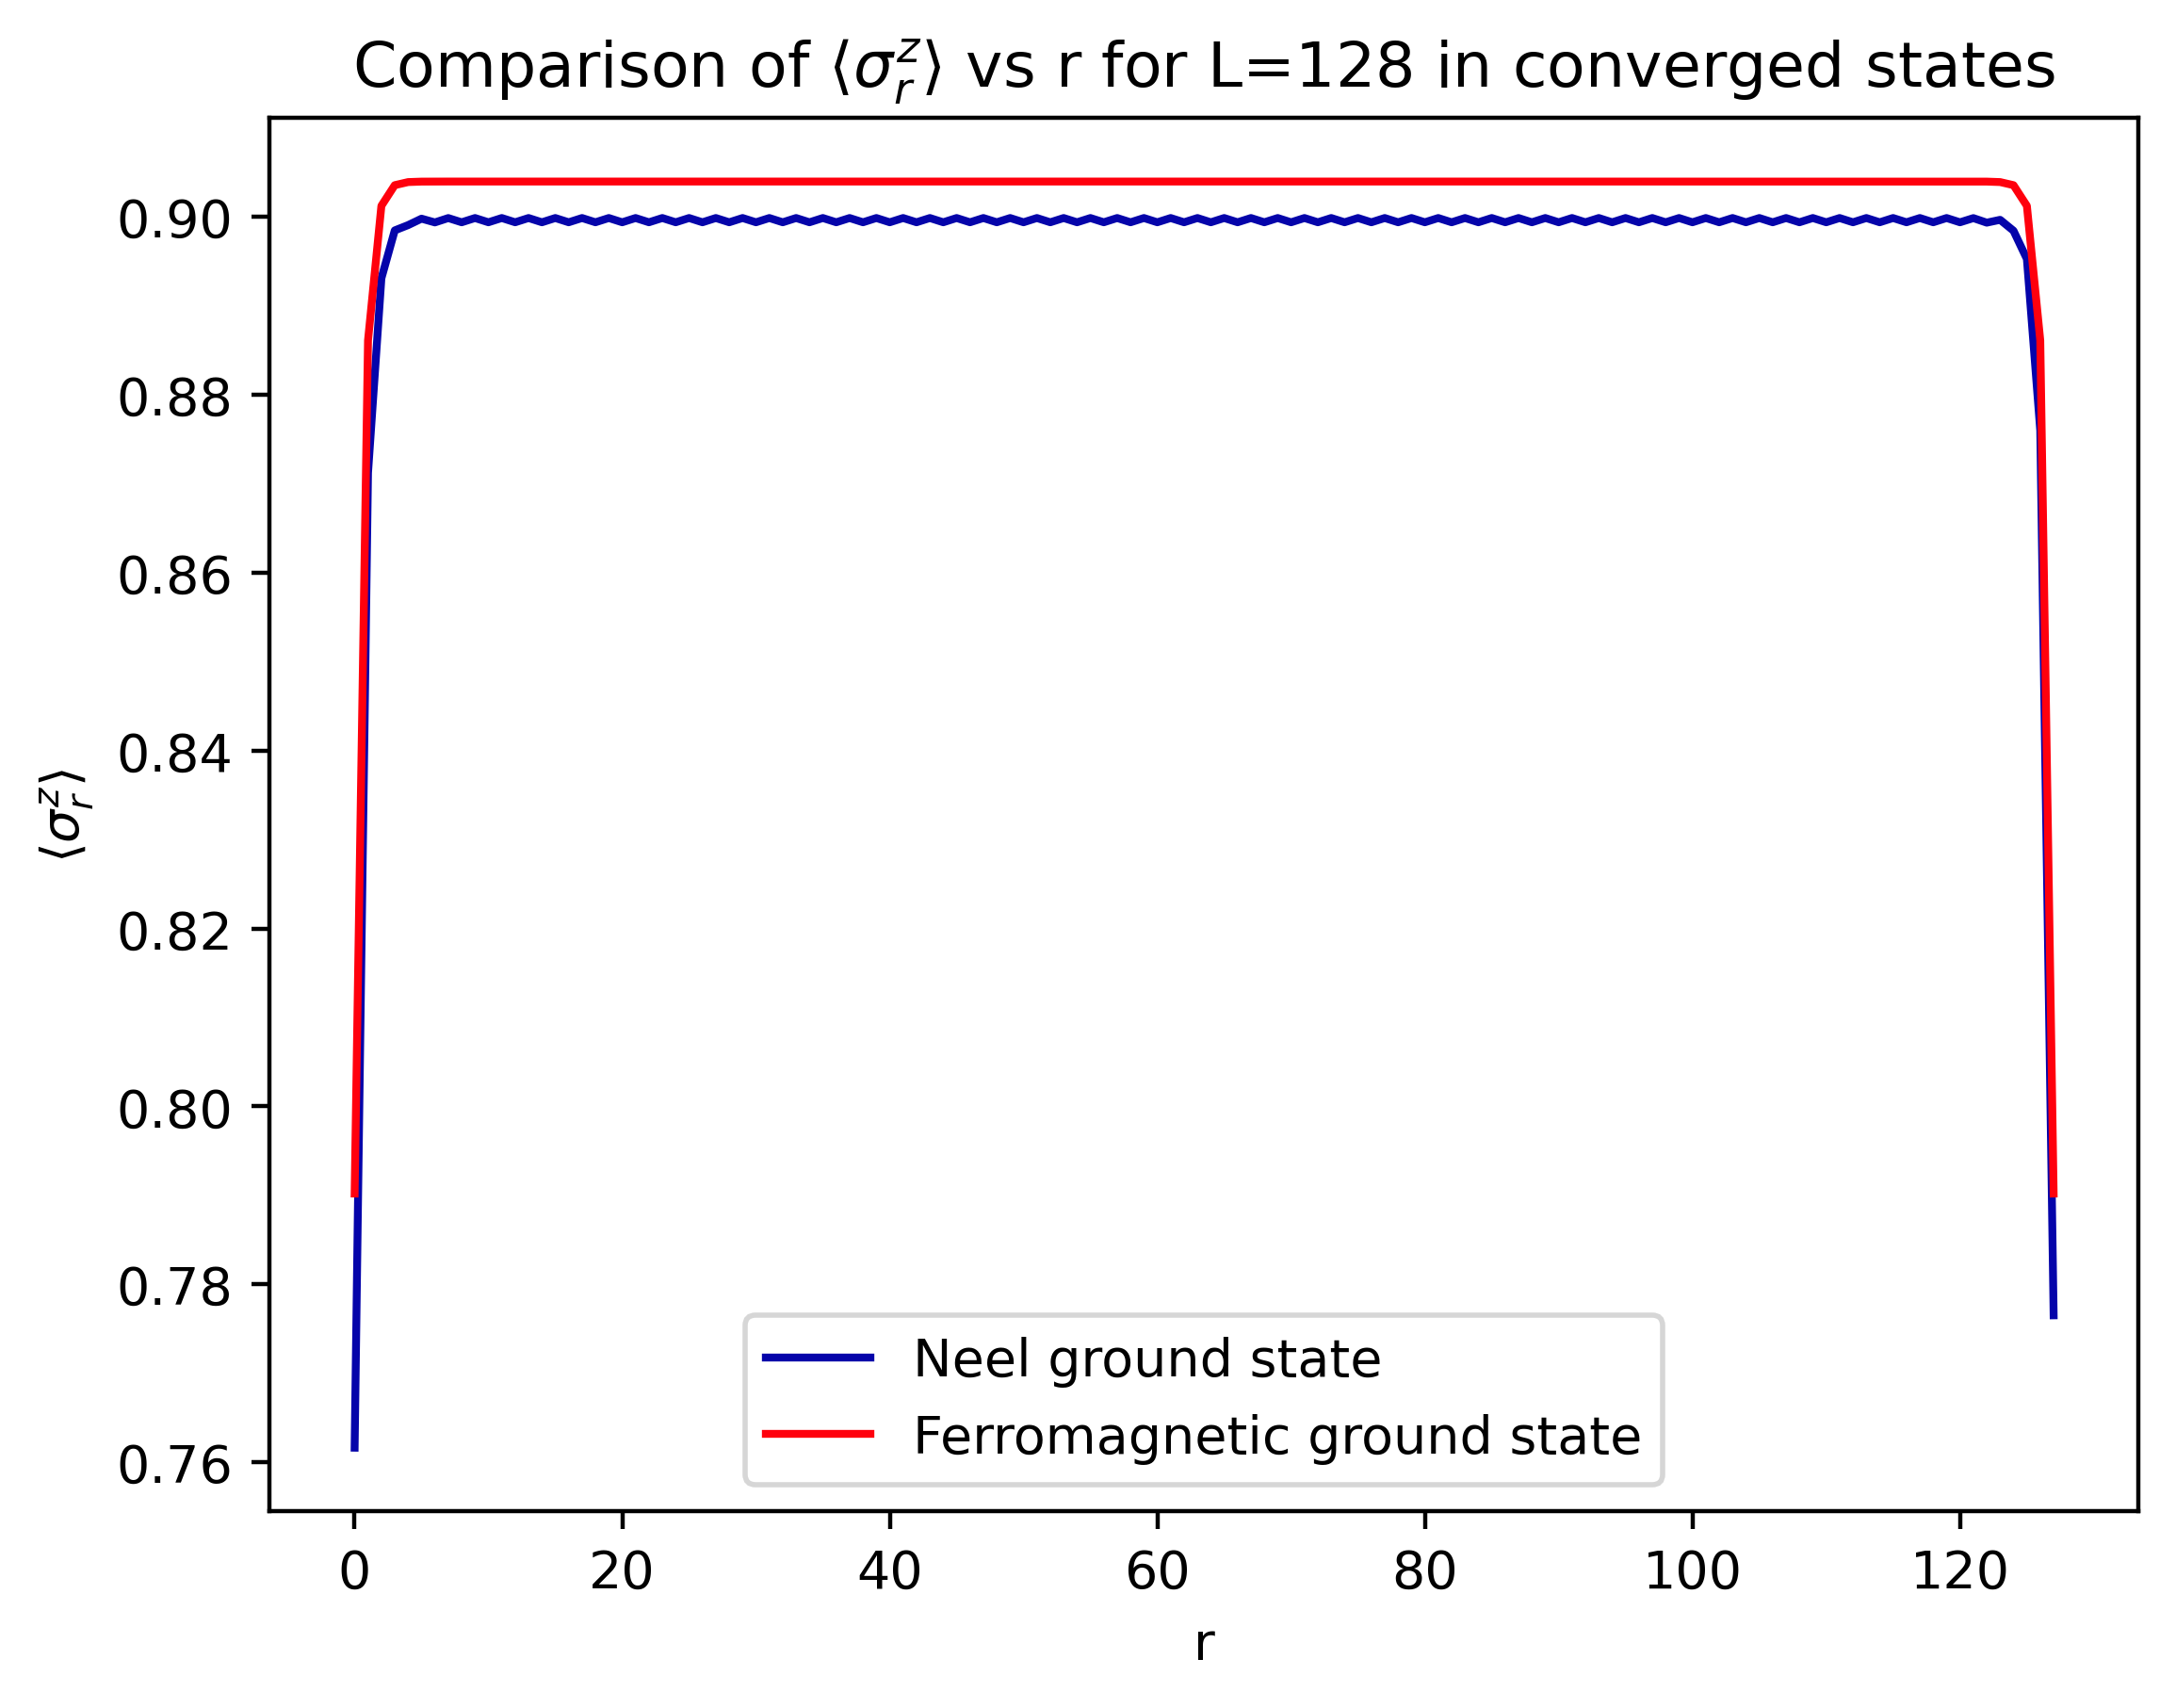

In [233]:
Rs=np.arange(0, L, 1)
plt.plot(Rs, correlators, color='xkcd:royal blue', label='Neel ground state')
plt.plot(Rs, correlators_ferro, color='xkcd:bright red', label='Ferromagnetic ground state')

plt.xlabel('r')
plt.ylabel(r'$\langle\sigma^z_{r}\rangle$')
plt.title(r'Comparison of $\langle\sigma^z_{r}\rangle$ vs r for L=128 in converged states')
plt.legend()
plt.savefig(os.path.join(directory, 'sigma_zp1neelvsferro.png'), dpi=400)
plt.show()

In [251]:
def entanglement_entropy(l, canonical_tracker):
    s = canonical_tracker[l][1]
    
    lambdas = s**2
    lambdas = lambdas/np.sum(lambdas)
    S = -np.sum(lambdas * np.log(lambdas))
    return S

C:\Users\cheru\AppData\Local\Temp\ipykernel_34724\2574989919.py:6: RuntimeWarning: divide by zero encountered in log
  S = -np.sum(lambdas * np.log(lambdas))
C:\Users\cheru\AppData\Local\Temp\ipykernel_34724\2574989919.py:6: RuntimeWarning: invalid value encountered in multiply
  S = -np.sum(lambdas * np.log(lambdas))


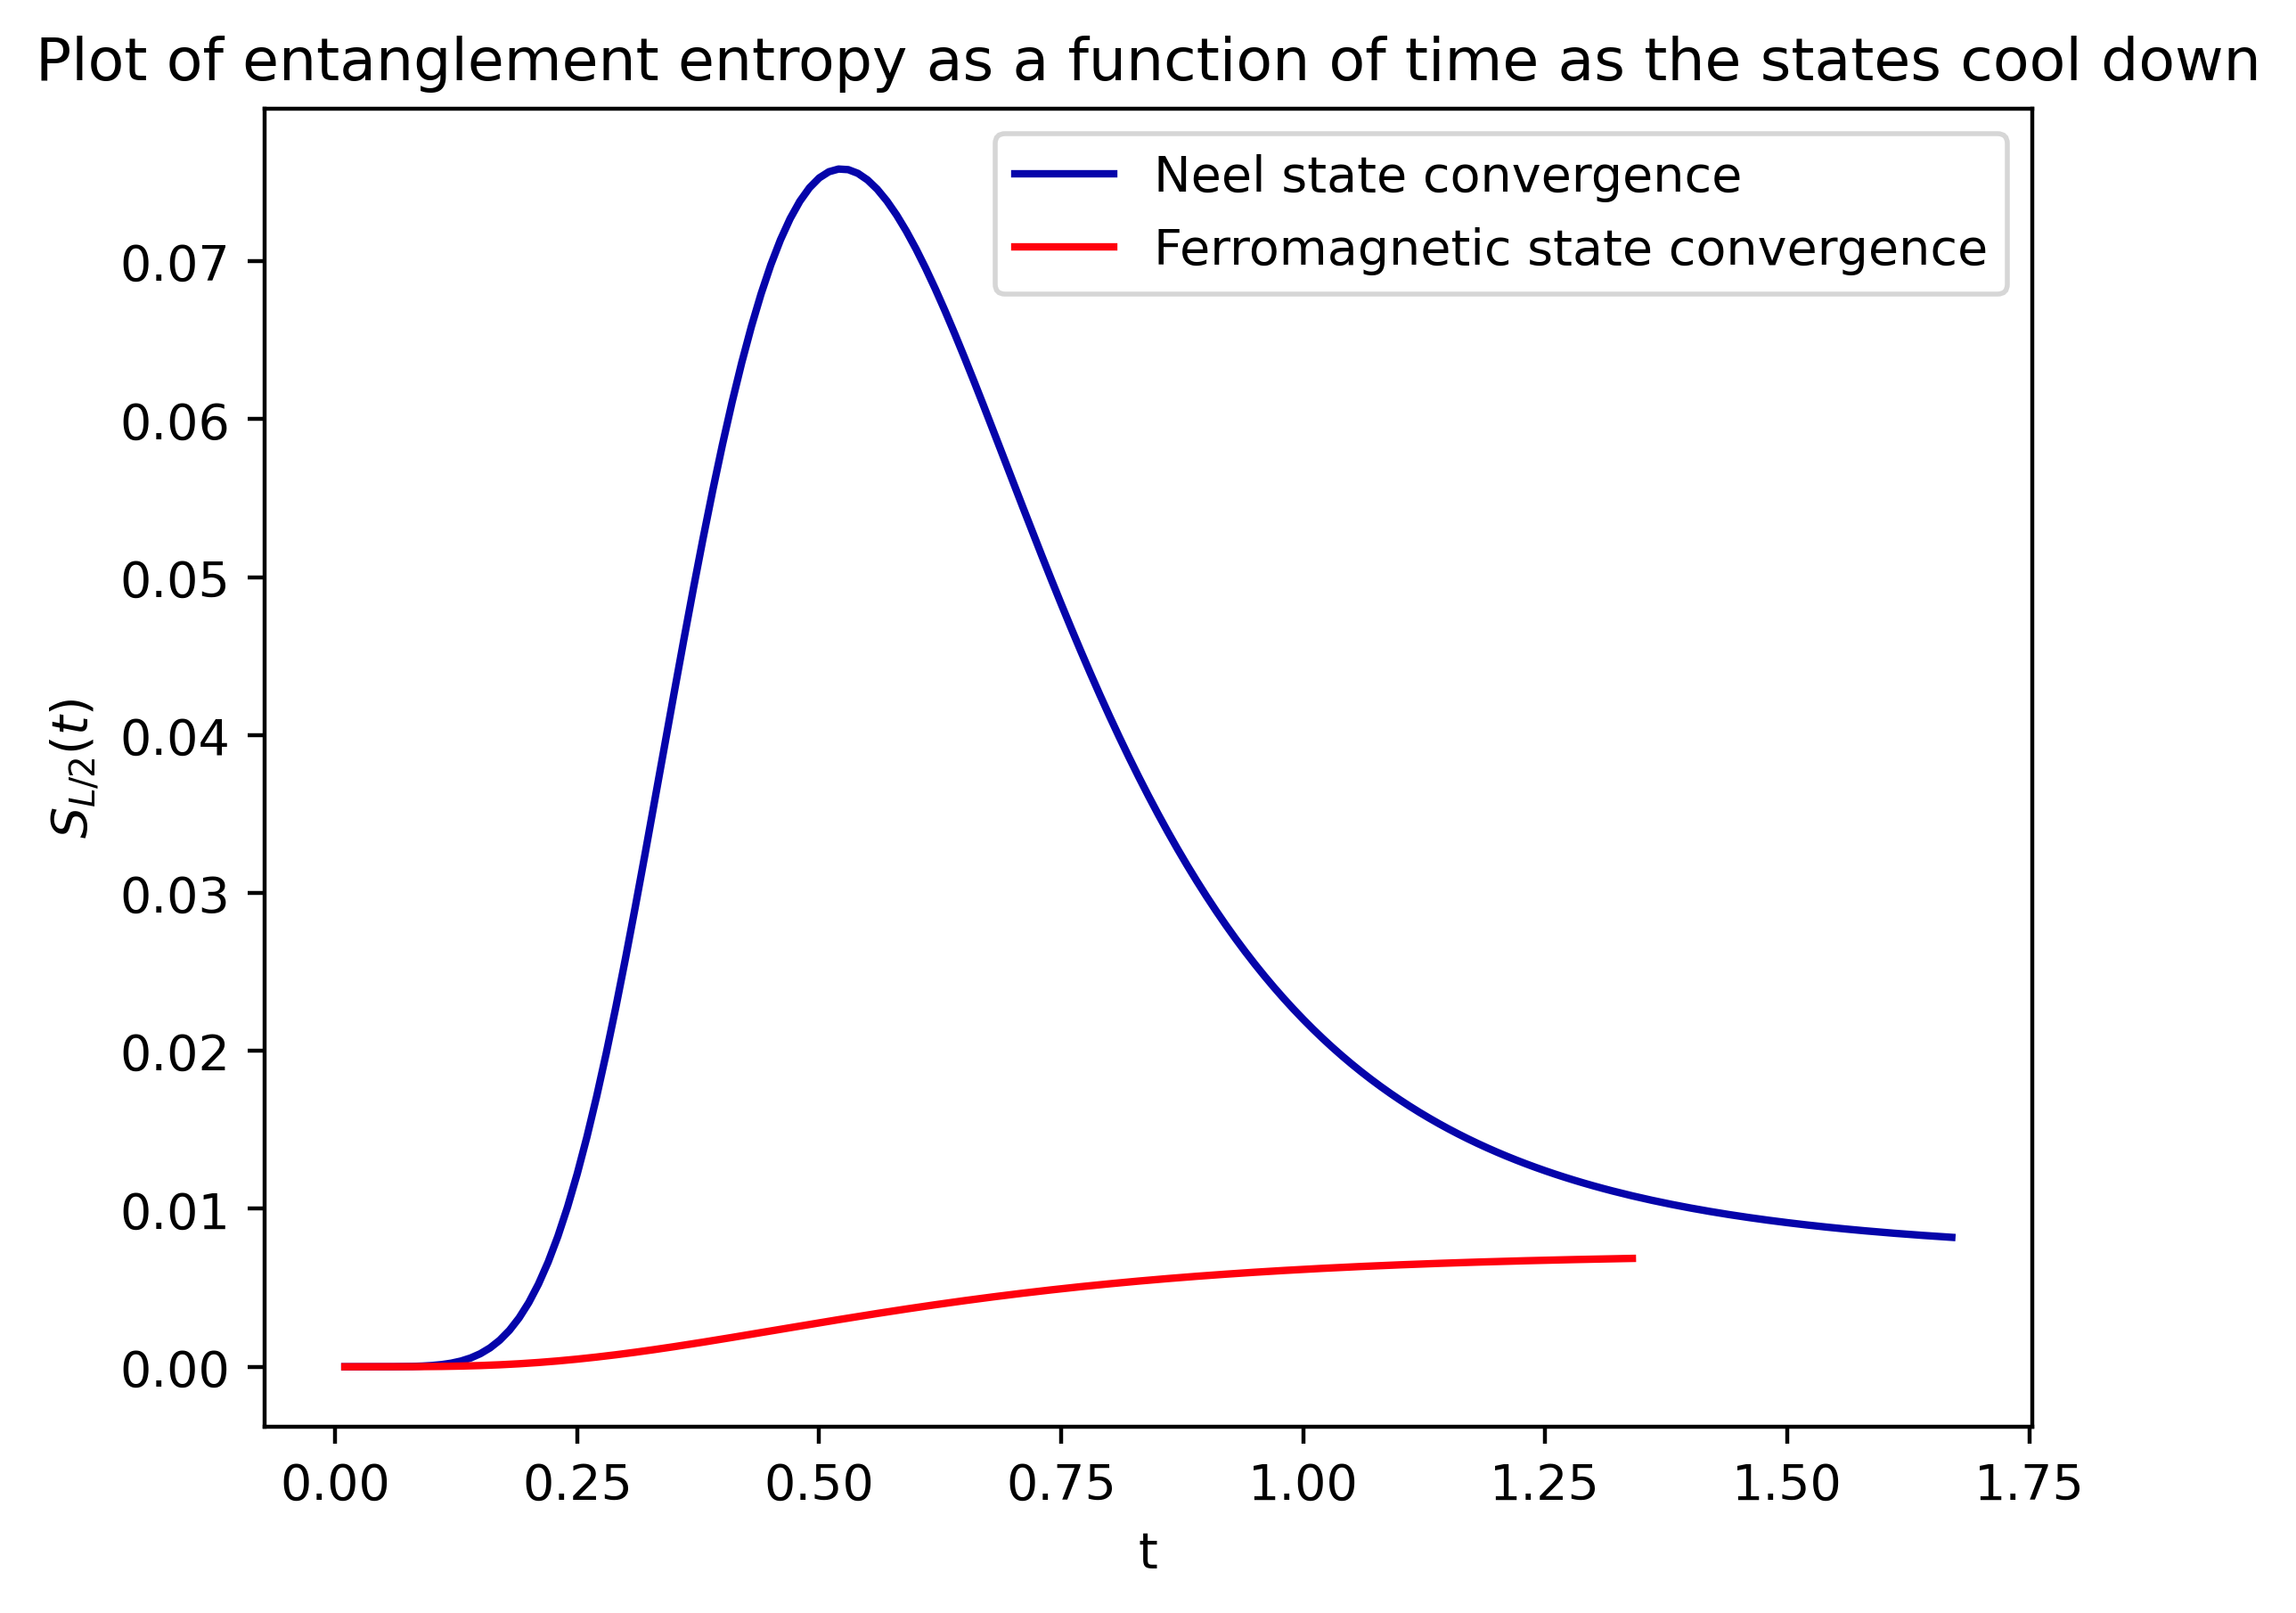

In [257]:
entropies = []
entropies_ferro = []
for i in range(len(canonical_trackers)):
    entropy = entanglement_entropy(L//2, canonical_trackers[i])
    entropies.append(entropy)
    
for i in range(len(canonical_trackers_ferro)):
    entropy = entanglement_entropy(L//2, canonical_trackers_ferro[i])
    entropies_ferro.append(entropy)    
    
    
plt.plot(np.arange(0, len(canonical_trackers), 1)*0.01, entropies, color='xkcd:royal blue', label='Neel state convergence')
plt.plot(np.arange(0, len(canonical_trackers_ferro), 1)*0.01, entropies_ferro, color='xkcd:bright red', label='Ferromagnetic state convergence')
plt.title('Plot of entanglement entropy as a function of time as the states cool down')
plt.legend()
plt.xlabel('t')
plt.ylabel(r'$S_{L/2}(t)$')
plt.savefig(os.path.join(directory, 'entropyp1neelvsferro.png'), dpi=400)


In [241]:
print(entanglement_entropy(64, canonical_tracker))
print(entanglement_entropy(64, canonical_tracker_ferro))

0.008196614033072154
0.006861189333010435
